# Implementation of Multilayer Perceptrons (MLP)

## Giới thiệu về Multilayer Perceptrons (MLP)

Multilayer Perceptrons (MLP) là một loại mạng nơ-ron nhân tạo bao gồm nhiều lớp, bao gồm lớp đầu vào, các lớp ẩn và lớp đầu ra. MLP có khả năng học các biểu diễn phi tuyến tính của dữ liệu, làm cho chúng phù hợp với các nhiệm vụ như phân loại và hồi quy. Đây là một trong những mô hình cơ bản của học sâu, được xây dựng dựa trên các nơ-ron kết nối đầy đủ giữa các lớp.

## Implementation

Trong phần này, chúng ta implement một MLP đơn giản bằng Python và NumPy. MLP bao gồm một lớp ẩn với hàm kích hoạt ReLU và lớp đầu ra với hàm softmax cho nhiệm vụ phân loại.

In [2]:
import numpy as np
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

### Khởi tạo tham số

Khởi tạo các ma trận trọng số và vector bias:
*   Hai ma trận trọng số W1 (784×256) và W2 (256×10), cùng hai vector bias b1 và b2
*   W1: Ma trận trọng số kết nối lớp đầu vào (input layer) với lớp ẩn (hidden layer)
*   W2: Ma trận trọng số kết nối lớp ẩn với lớp đầu ra (output layer).
*   W1 và W2 được khởi tạo ngẫu nhiên (Tránh sự đối xứng: Nếu tất cả trọng số giống nhau, các neuron sẽ học giống nhau → Mạng không hiệu quả) với phân phối chuẩn (Gaussian) với mean = 0, variance = 1 (np.random.randn). Nhân với sigma để kiểm soát phương sai (tránh gradient quá lớnlớn - Exploding Gradient hoặc quá nhỏ - Vanishing gradient)
*   b1: Vector bias cho lớp ẩn, giúp mô hình linh hoạt hơn bằng cách dịch chuyển đầu ra.
*   b2: Vector bias cho lớp đầu ra, giúp điều chỉnh giá trị đầu ra cuối cùng.
*   b1, b2 thường được khởi tạo bằng 0 để đảm bảo tính đối xứng ban đầu. Đôi khi có thể khởi tạo giá trị nhỏ (ví dụ: 0.01) để tránh Dying ReLU khi dùng ReLU.

In [3]:
def init_params(num_inputs, num_hiddens, num_outputs, sigma=0.01):
    params = {
        'W1': np.random.randn(num_inputs, num_hiddens) * sigma,
        'b1': np.zeros((1, num_hiddens)),
        'W2': np.random.randn(num_hiddens, num_outputs) * sigma,
        'b2': np.zeros((1, num_outputs)),
    }
    return params, num_inputs

### Hàm kích hoạt ReLU
ReLU (Rectified Linear Unit) là hàm kích hoạt phi tuyến được sử dụng phổ biến nhất trong các mạng neural sâu (Deep Neural Networks). Nó giúp giải quyết vấn đề vanishing gradient và tăng tốc độ hội tụ của mô hình.
$$\operatorname{ReLU}(z) = \max(z, 0).$$
*   Đơn giản, tính toán nhanh. Chỉ cần so sánh và gán giá trị, không cần phép toán phức tạp như sigmoid/tanh
*   Giảm thiểu vanishing gradient (Đạo hàm = 1 khi x > 0, giữ gradient không bị suy giảm qua các lớp.) so với sigmoid/tanh

In [4]:
def relu(Z):
    return np.maximum(0, Z)

### Softmax cho đầu ra logits
$$\hat{\mathbf{y}} = \mathrm{softmax}(\mathbf{z}) \quad \textrm{where}\quad \hat{y}_i = \frac{\exp(z_i)}{\sum_j \exp(z_j)}.$$
Biến đầu ra thô (logits) từ lớp cuối cùng (Z) thành phân phối xác suất với các giá trị nằm trong khoảng [0, 1] và tổng = 1. \
Trong thực tế ta dùng `np.exp(Z - np.max(Z, axis=1, keepdims=True))` mà không dùng `np.exp(Z)` để ngăn chặn tràn số khi giá trị trong Z quá lớn. Việc trừ đi giá trị cực đại trên mỗi dòng (hoặc mỗi vector logits) không làm thay đổi kết quả cuối cùng của Softmax về mặt toán học nhưng giúp các giá trị đầu vào cho hàm mũ luôn ≤ 0, từ đó giới hạn kết quả của np.exp trong khoảng
(0,1]và đảm bảo tính ổn định số học

In [5]:
def softmax(Z):
    exp_Z = np.exp(Z - np.max(Z, axis=1, keepdims=True))
    return exp_Z / np.sum(exp_Z, axis=1, keepdims=True)

### Lan truyền thuận Forward Propagation

Tính toán đầu ra của mạng:
*   Lớp ẩn
$$Z_1 = XW_1 + b_1$$
 Tương ứng công thức 5.3.1
$$\mathbf{z}= \mathbf{W}^{(1)} \mathbf{x}$$
Z1: ma trận của lớp ẩn  
X: ma trận 2D chứa dữ liệu ảnh đã được flatten từ tensor batch X_train \
W1: ma trận trọng số lớp ẩn \
b1: Bias lớp ẩn
$$\quad A_1 = \mathrm{max}(Z_1,0)$$
 Tương ứng công thức 5.3.2
$$\mathbf{h}= \phi (\mathbf{z})$$
A1: ma trận được tạo bởi hàm kích hoạt ReLU
*   Lớp đầu ra (logits)
$$Z_2 = A_1W_2 + b_2$$
 Tương ứng công thức 5.3.3
$$\mathbf{o}= \mathbf{W}^{(2)} \mathbf{h}$$
Z2: ma trận của đầu ra  
A1: ma trận được tạo bởi hàm kích hoạt ReLU \
W2: ma trận trọng số lớp đầu ra \
b1: Bias lớp đầu ra
$$\quad \hat Y = \mathrm{Softmax}(Z_2)$$

In [6]:
def forward_propagation(X, params):
    W1, b1, W2, b2 = params['W1'], params['b1'], params['W2'], params['b2']
    # Lớp ẩn
    Z1 = X.dot(W1) + b1
    A1 = relu(Z1)                    # kích hoạt
    # Lớp đầu ra
    Z2 = A1.dot(W2) + b2
    Y_hat = softmax(Z2)              # xác suất dự đoán
    return Z1, A1, Z2, Y_hat

### Hàm mất mát cross-entropy
Tính loss trung bình của Cross-Entropy và gradient
*   cross-entropy loss
$$ l(\mathbf{y}, \hat{\mathbf{y}})_{sum} = - \sum_{j=1}^m y_j \log \hat{y}_j. $$
*   cross-entropy trung bình, tránh cho giá trị loss tăng tỷ lệ thuận với m (số mẫu của bach) khiến cho giá trị loss của bacth có size lớn khác với batch có size nhỏ
$$ l(\mathbf{y}, \hat{\mathbf{y}})_{mean} = -  \frac{1}{m}\sum_{j=1}^m y_j \log \hat{y}_j. $$
*   Gradient
$$
\partial_{z_j} l(\mathbf{y}, \hat{\mathbf{y}}) = \frac{\partial L}{\partial z_j} = \frac{1}{m}(\hat{y}_j - y_j).
$$

$y_ {j}$ là giá trị one-hot (bằng 1 nếu j là nhãn đúng, và 0 cho các nhãn khác). Khi cập nhật gradient cho lớp đúng, $y_ {j}$ = 1 nên ta có $\hat{y}_{j}$ - 1
$$
\partial_{z_j} l(\mathbf{y}, \hat{\mathbf{y}}) = \frac{\partial L}{\partial z_j} = \frac{1}{m}(\hat{y}_j - 1).
$$




In [7]:
def cross_entropy_loss(Y_hat, Y):
    m = Y.shape[0]
    # loss
    log_likelihood = -np.log(Y_hat[np.arange(m), Y] + 1e-9)
    loss = np.sum(log_likelihood) / m
    # gradient
    dZ2 = Y_hat.copy()
    dZ2[np.arange(m), Y] -= 1
    dZ2 /= m
    return loss, dZ2

### Đạo hàm của ReLU
Đạo hàm của ReLU rất đơn giản, giúp tính gradient hiệu quả trong quá trình lan truyền ngược (backpropagation)
$$\frac{\partial}{\partial z}\mathrm{ReLU}(z) = \begin{cases} 1 & \text{nếu }z>0,\\ 0 & \text{nếu }z \le 0. \end{cases}$$
*   Tại x = 0: ReLU không khả vi, nhưng trong thực tế, ta thường chọn giá trị 0 hoặc 1.



In [8]:
def relu_derivative(Z):
    return (Z > 0).astype(float)

### Lan truyền ngược và cập nhật tham số

Tính gradient và cập nhật tham số bằng gradient descent:
*   Gradient của loss theo logits: `_, dZ2 = cross_entropy_loss(Y_hat, Y)`
$$dZ_2=\frac{\partial L}{\partial z_2}$$
 Tương ứng công thức 5.3.9
$$\frac{\partial J}{\partial \mathbf{o}}
= \frac{\partial L}{\partial \mathbf{o}}
\in \mathbb{R}^q$$
*   Gradient w.r.t. W₂ và b₂: \
`dW2 = A1.T.dot(dZ2)`                         
$$dW_2=\mathbf{A_1}^\top dZ_2$$
 Tương ứng công thức 5.3.11
 $$\frac{\partial J}{\partial \mathbf{W}^{(2)}}= \frac{\partial J}{\partial \mathbf{o}} \mathbf{h}^\top$$
`db2 = np.sum(dZ2, axis=0, keepdims=True)`
$$db2=\sum_{i=1}^m dZ_{2,i}$$
*   Gradient w.r.t. đầu ra lớp ẩn: `dA1 = dZ2.dot(W2.T)`
$$dA_1=dZ_2\mathbf{W_2}^\top $$
Tương ứng công thức 5.3.12
$$\frac{\partial J}{\partial \mathbf{h}}
= {\mathbf{W}^{(2)}}^\top \frac{\partial J}{\partial \mathbf{o}}$$
*   Đạo hàm ReLU: `dZ1 = dA1 * relu_derivative(Z1)`
 $$A_1 = \mathrm{ReLU}(Z_1)$$
 Nên
 $$dZ_1=dA_1 \odot \phi'\left(\mathbf{Z_1}\right)$$
 Tương ứng công thức 5.3.13
 $$\frac{\partial J}{\partial \mathbf{z}} = \frac{\partial J}{\partial \mathbf{h}} \odot \phi'\left(\mathbf{z}\right)$$
*   Gradient w.r.t. W₁ và b₁: \
`dW1 = X.T.dot(dZ1)`                         
$$dW_1=\mathbf{X}^\top dZ_1$$
 Tương ứng công thức 5.3.11
 $$\frac{\partial J}{\partial \mathbf{W}^{(1)}} = \frac{\partial J}{\partial \mathbf{z}} \mathbf{x}^\top$$
`db1 = np.sum(dZ1, axis=0, keepdims=True)`
$$db1=\sum_{i=1}^m dZ_{1,i}$$
*   Cập nhật tham số
$$W1_{new}=W1_{old} - \alpha.\frac{\partial L}{\partial W1}$$
`α: Learning rate` \
$\frac{\partial L}{\partial W1}$: Gradient của loss L theo W1 (chính là `grads['dW1']`).

In [9]:
def backward_propagation(X, Y, cache, params):
    W1, W2 = params['W1'], params['W2']
    Z1, A1, Z2, Y_hat = cache

    # Lấy gradient từ loss
    _, dZ2 = cross_entropy_loss(Y_hat, Y)
    # Gradients cho W2, b2
    dW2 = A1.T.dot(dZ2)
    db2 = np.sum(dZ2, axis=0, keepdims=True)
    # Backprop vào lớp ẩn
    dA1 = dZ2.dot(W2.T)
    dZ1 = dA1 * relu_derivative(Z1)
    # Gradients cho W1, b1
    dW1 = X.T.dot(dZ1)
    db1 = np.sum(dZ1, axis=0, keepdims=True)

    return {'dW1': dW1, 'db1': db1, 'dW2': dW2, 'db2': db2}

def update_params(params, grads, learning_rate):
    params['W1'] -= learning_rate * grads['dW1']
    params['b1'] -= learning_rate * grads['db1']
    params['W2'] -= learning_rate * grads['dW2']
    params['b2'] -= learning_rate * grads['db2']

### Đánh giá độ chính xác

In [10]:
def evaluate_accuracy(data_loader, params, num_inputs):
    correct = total = 0
    for X_t, y_t in data_loader:
        X_np = X_t.numpy().reshape(-1, num_inputs)
        Z1, A1, Z2, Y_hat = forward_propagation(X_np, params)
        y_pred = np.argmax(Y_hat, axis=1)
        correct += np.sum(y_pred == y_t.numpy())
        total += y_t.shape[0]
    return correct / total

def evaluate_loss(data_loader, params, num_inputs):
    total_loss = 0.0
    total_samples = 0
    for X_t, y_t in data_loader:
        X_np = X_t.numpy().reshape(-1, num_inputs)
        _, _, _, Y_hat = forward_propagation(X_np, params)
        loss, _ = cross_entropy_loss(Y_hat, y_t.numpy())
        total_loss += loss * X_np.shape[0]
        total_samples += X_np.shape[0]
    return total_loss / total_samples

### Tải dữ liệu Fashion-MNIST

In [11]:
def load_Fashion_MNIST_data(batch_size):
    # Tải dữ liệu Fashion-MNIST
    transform = transforms.Compose([transforms.ToTensor()])
    train_ds = datasets.FashionMNIST(root='data', train=True, download=True, transform=transform)
    test_ds = datasets.FashionMNIST(root='data', train=False, download=True, transform=transform)
    train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_ds, batch_size=batch_size, shuffle=False)
    return train_ds, test_ds, train_loader, test_loader

In [12]:
batch_size      = 256
train_ds, test_ds, train_loader, test_loader = load_Fashion_MNIST_data(batch_size)

### Huấn luyện mô hình

In [18]:
def train_model(num_inputs, num_hiddens, num_outputs, learning_rate=0.1, sigma=0.01, num_epochs=10):
    train_losses = []
    test_losses = []
    train_accs = []
    test_accs = []
    params, num_inputs = init_params(num_inputs, num_hiddens, num_outputs, sigma)
    # Vòng lặp huấn luyện
    for epoch in range(1, num_epochs+1):
        epoch_loss = 0.0
        for X_t, y_t in train_loader:
            # Chuyển sang numpy
            X_np = X_t.numpy().reshape(-1, num_inputs)
            y_np = y_t.numpy()

            # Forward
            cache = forward_propagation(X_np, params)
            _, _, _, Y_hat = cache

            # Tính loss
            loss, _ = cross_entropy_loss(Y_hat, y_np)
            epoch_loss += loss * X_np.shape[0]

            # Backward
            grads = backward_propagation(X_np, y_np, cache, params)

            # Cập nhật tham số
            update_params(params, grads, learning_rate)

        # Tính và lưu kết quả sau mỗi epoch
        train_losses.append(epoch_loss / len(train_ds))
        train_accs.append(evaluate_accuracy(train_loader, params, num_inputs))
        test_accs.append(evaluate_accuracy(test_loader, params, num_inputs))
        test_losses.append(evaluate_loss(test_loader, params, num_inputs))

        print(f"Epoch {epoch}: "
              f"train_loss={train_losses[-1]:.4f}, "
              f"test_loss={test_losses[-1]:.4f}, "
              f"train_acc={train_accs[-1]:.4f}, "
              f"test_acc={test_accs[-1]:.4f}")

    return num_epochs, train_losses, test_losses, train_accs, test_accs

In [20]:
num_inputs      = 784
num_hiddens     = 256
num_outputs     = 10
learning_rate   = 0.1
sigma           = 0.01
num_epochs      = 10

num_epochs, train_losses, test_losses, train_accs, test_accs = train_model(num_inputs, num_hiddens, num_outputs, learning_rate, sigma,num_epochs)

Epoch 1: train_loss=1.0382, test_loss=0.6773, train_acc=0.7700, test_acc=0.7557
Epoch 2: train_loss=0.5959, test_loss=0.5624, train_acc=0.8167, test_acc=0.8028
Epoch 3: train_loss=0.5126, test_loss=0.5342, train_acc=0.8229, test_acc=0.8081
Epoch 4: train_loss=0.4805, test_loss=0.4778, train_acc=0.8446, test_acc=0.8317
Epoch 5: train_loss=0.4511, test_loss=0.4707, train_acc=0.8477, test_acc=0.8326
Epoch 6: train_loss=0.4291, test_loss=0.4848, train_acc=0.8371, test_acc=0.8210
Epoch 7: train_loss=0.4184, test_loss=0.4783, train_acc=0.8409, test_acc=0.8260
Epoch 8: train_loss=0.4025, test_loss=0.4896, train_acc=0.8314, test_acc=0.8120
Epoch 9: train_loss=0.3926, test_loss=0.4166, train_acc=0.8657, test_acc=0.8511
Epoch 10: train_loss=0.3809, test_loss=0.4092, train_acc=0.8705, test_acc=0.8536


### Tạo graph

In [21]:
def show_training_graphs(num_epochs, train_losses, test_losses, train_accs, test_accs, layer_dims_str=""):
    # Vẽ graph
    plt.figure(figsize=(12, 6))
    epochs_range = list(range(1, num_epochs+1))
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, train_losses, label='Train Loss')
    plt.plot(epochs_range, test_losses, label='Test Loss')
    plt.title(f'Loss over Epochs {layer_dims_str}')
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()
    plt.grid(True)

    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, train_accs, label='Train Accuracy')
    plt.plot(epochs_range, test_accs, label='Test Accuracy')
    plt.title(f'Accuracy over Epochs {layer_dims_str}')
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()

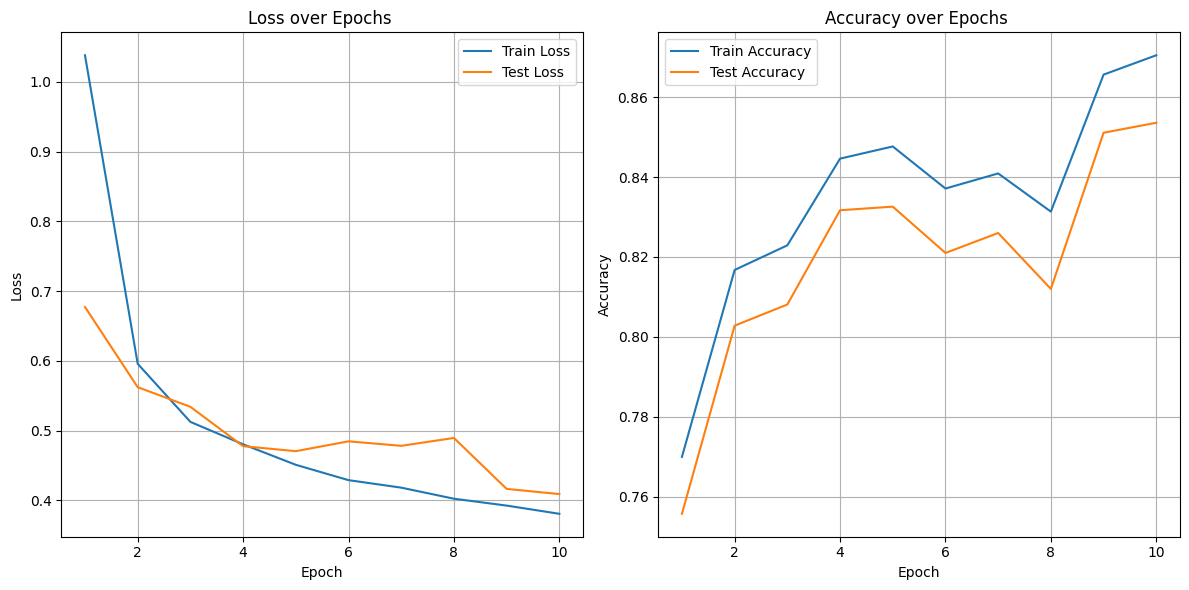

In [22]:
show_training_graphs(num_epochs, train_losses, test_losses, train_accs, test_accs)

## Exercises

### 1: Change the number of hidden units num_hiddens and plot how its number affects the accuracy of the model. What is the best value of this hyperparameter?



In [23]:
def gen_logrithm_nums(initial_value = 5, growth_factor = 2, num_elements = 12):
    return [initial_value * growth_factor**i for i in range(num_elements)]


Training with num_hiddens = 64
Epoch 1: train_loss=1.1505, test_loss=0.7288, train_acc=0.7189, test_acc=0.7113
Epoch 2: train_loss=0.6305, test_loss=0.6315, train_acc=0.7710, test_acc=0.7558
Epoch 3: train_loss=0.5357, test_loss=0.5448, train_acc=0.8196, test_acc=0.8108
Epoch 4: train_loss=0.4951, test_loss=0.4990, train_acc=0.8382, test_acc=0.8249
Epoch 5: train_loss=0.4686, test_loss=0.5929, train_acc=0.7920, test_acc=0.7853
Epoch 6: train_loss=0.4469, test_loss=0.5375, train_acc=0.8119, test_acc=0.7942
Epoch 7: train_loss=0.4341, test_loss=0.4509, train_acc=0.8545, test_acc=0.8396
Epoch 8: train_loss=0.4195, test_loss=0.4805, train_acc=0.8407, test_acc=0.8266
Epoch 9: train_loss=0.4095, test_loss=0.5321, train_acc=0.8145, test_acc=0.7962
Epoch 10: train_loss=0.3960, test_loss=0.4570, train_acc=0.8536, test_acc=0.8381


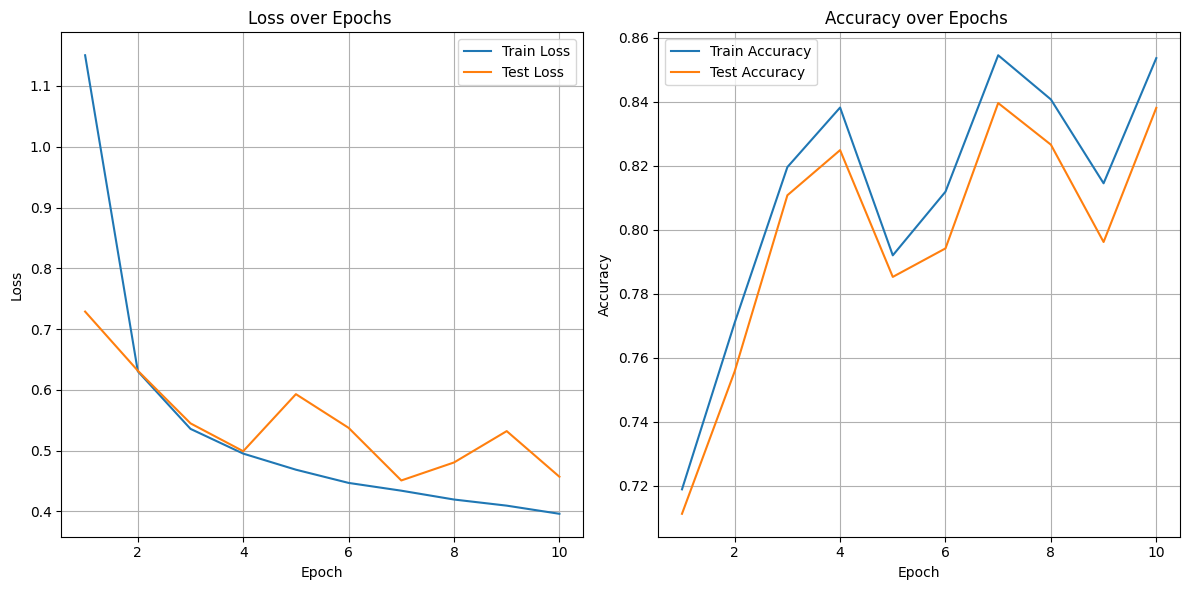

Final Test Accuracy for 64 hidden units: 0.8381

Training with num_hiddens = 128
Epoch 1: train_loss=1.0916, test_loss=0.7142, train_acc=0.7531, test_acc=0.7447
Epoch 2: train_loss=0.6162, test_loss=0.5852, train_acc=0.8018, test_acc=0.7912
Epoch 3: train_loss=0.5286, test_loss=0.5885, train_acc=0.7934, test_acc=0.7832
Epoch 4: train_loss=0.4884, test_loss=0.4895, train_acc=0.8427, test_acc=0.8302
Epoch 5: train_loss=0.4601, test_loss=0.4779, train_acc=0.8470, test_acc=0.8347
Epoch 6: train_loss=0.4398, test_loss=0.4778, train_acc=0.8427, test_acc=0.8298
Epoch 7: train_loss=0.4235, test_loss=0.5313, train_acc=0.8150, test_acc=0.8007
Epoch 8: train_loss=0.4087, test_loss=0.5219, train_acc=0.8177, test_acc=0.8000
Epoch 9: train_loss=0.3979, test_loss=0.4547, train_acc=0.8493, test_acc=0.8337
Epoch 10: train_loss=0.3875, test_loss=0.4281, train_acc=0.8625, test_acc=0.8452


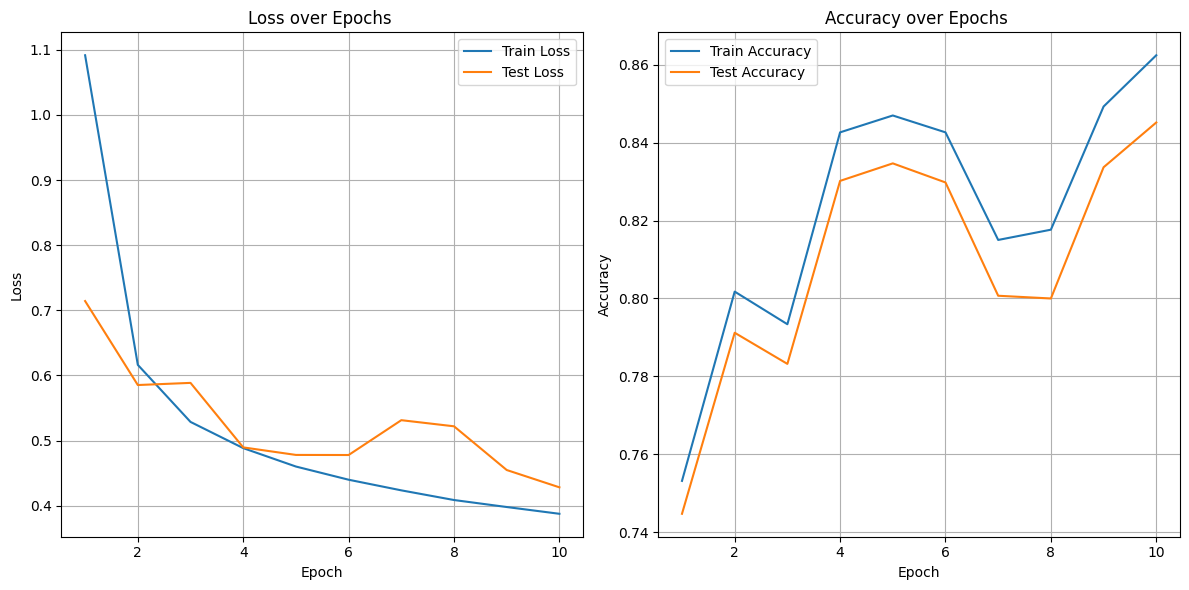

Final Test Accuracy for 128 hidden units: 0.8452

Training with num_hiddens = 256
Epoch 1: train_loss=1.0437, test_loss=0.7123, train_acc=0.7607, test_acc=0.7510
Epoch 2: train_loss=0.6002, test_loss=0.5650, train_acc=0.8080, test_acc=0.7948
Epoch 3: train_loss=0.5207, test_loss=0.5324, train_acc=0.8255, test_acc=0.8124
Epoch 4: train_loss=0.4799, test_loss=0.5022, train_acc=0.8336, test_acc=0.8199
Epoch 5: train_loss=0.4581, test_loss=0.5020, train_acc=0.8367, test_acc=0.8262
Epoch 6: train_loss=0.4382, test_loss=0.4574, train_acc=0.8518, test_acc=0.8366
Epoch 7: train_loss=0.4216, test_loss=0.5142, train_acc=0.8282, test_acc=0.8155
Epoch 8: train_loss=0.4063, test_loss=0.4379, train_acc=0.8581, test_acc=0.8426
Epoch 9: train_loss=0.3934, test_loss=0.4359, train_acc=0.8600, test_acc=0.8444
Epoch 10: train_loss=0.3846, test_loss=0.4702, train_acc=0.8421, test_acc=0.8258


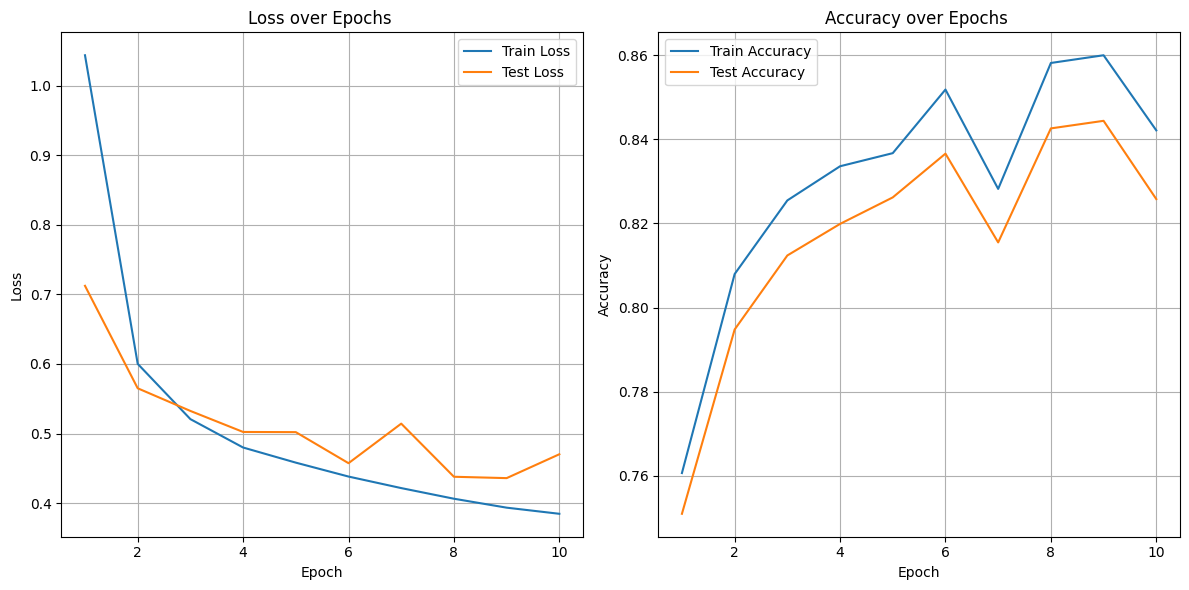

Final Test Accuracy for 256 hidden units: 0.8258

Training with num_hiddens = 512
Epoch 1: train_loss=0.9877, test_loss=0.7275, train_acc=0.7384, test_acc=0.7267
Epoch 2: train_loss=0.5824, test_loss=0.6738, train_acc=0.7728, test_acc=0.7630
Epoch 3: train_loss=0.5133, test_loss=0.5085, train_acc=0.8337, test_acc=0.8205
Epoch 4: train_loss=0.4771, test_loss=0.4930, train_acc=0.8378, test_acc=0.8243
Epoch 5: train_loss=0.4462, test_loss=0.5093, train_acc=0.8272, test_acc=0.8125
Epoch 6: train_loss=0.4296, test_loss=0.4539, train_acc=0.8519, test_acc=0.8377
Epoch 7: train_loss=0.4143, test_loss=0.4503, train_acc=0.8547, test_acc=0.8414
Epoch 8: train_loss=0.3996, test_loss=0.4448, train_acc=0.8538, test_acc=0.8413
Epoch 9: train_loss=0.3908, test_loss=0.4282, train_acc=0.8633, test_acc=0.8453
Epoch 10: train_loss=0.3780, test_loss=0.4336, train_acc=0.8607, test_acc=0.8430


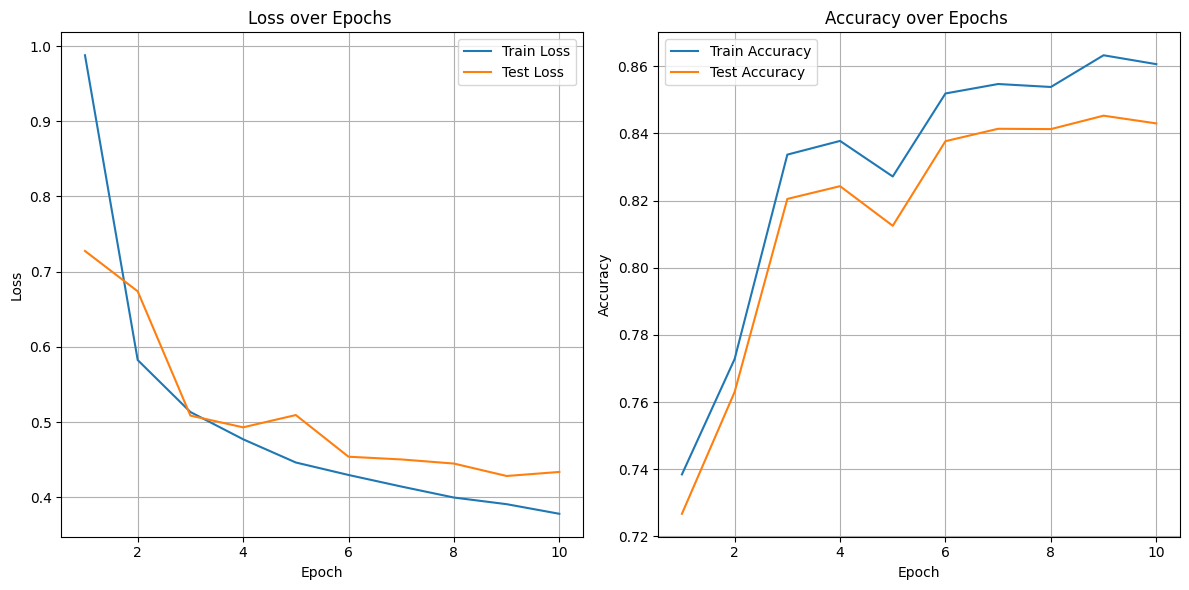

Final Test Accuracy for 512 hidden units: 0.8430

Training with num_hiddens = 1024
Epoch 1: train_loss=0.9317, test_loss=0.6384, train_acc=0.7936, test_acc=0.7790
Epoch 2: train_loss=0.5649, test_loss=0.6167, train_acc=0.7996, test_acc=0.7901
Epoch 3: train_loss=0.5037, test_loss=0.5040, train_acc=0.8351, test_acc=0.8230
Epoch 4: train_loss=0.4696, test_loss=0.4760, train_acc=0.8466, test_acc=0.8328
Epoch 5: train_loss=0.4396, test_loss=0.4677, train_acc=0.8492, test_acc=0.8310
Epoch 6: train_loss=0.4221, test_loss=0.4451, train_acc=0.8573, test_acc=0.8414
Epoch 7: train_loss=0.4059, test_loss=0.4909, train_acc=0.8338, test_acc=0.8139
Epoch 8: train_loss=0.3954, test_loss=0.4299, train_acc=0.8613, test_acc=0.8475
Epoch 9: train_loss=0.3823, test_loss=0.4426, train_acc=0.8560, test_acc=0.8416
Epoch 10: train_loss=0.3730, test_loss=0.4187, train_acc=0.8670, test_acc=0.8515


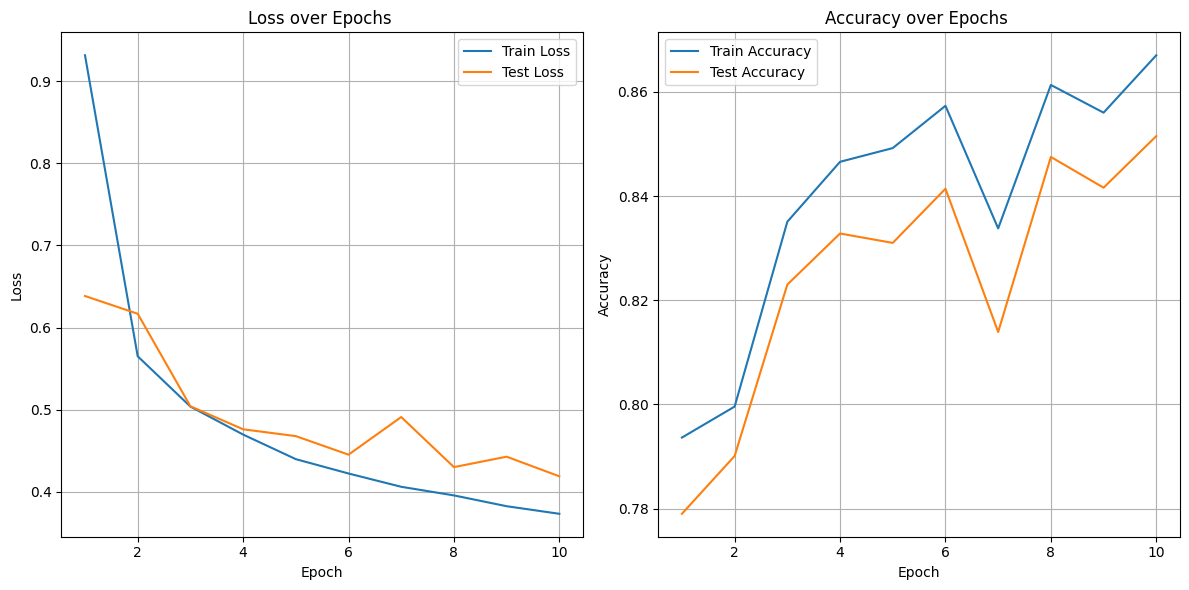

Final Test Accuracy for 1024 hidden units: 0.8515

Training with num_hiddens = 2048
Epoch 1: train_loss=0.8731, test_loss=0.7085, train_acc=0.7388, test_acc=0.7227
Epoch 2: train_loss=0.5571, test_loss=0.6043, train_acc=0.8062, test_acc=0.7941
Epoch 3: train_loss=0.4952, test_loss=0.5376, train_acc=0.8163, test_acc=0.7990
Epoch 4: train_loss=0.4583, test_loss=0.4643, train_acc=0.8507, test_acc=0.8368
Epoch 5: train_loss=0.4332, test_loss=0.4652, train_acc=0.8489, test_acc=0.8336
Epoch 6: train_loss=0.4161, test_loss=0.4707, train_acc=0.8472, test_acc=0.8307
Epoch 7: train_loss=0.4007, test_loss=0.4422, train_acc=0.8571, test_acc=0.8402
Epoch 8: train_loss=0.3881, test_loss=0.4264, train_acc=0.8649, test_acc=0.8462
Epoch 9: train_loss=0.3765, test_loss=0.4115, train_acc=0.8710, test_acc=0.8557
Epoch 10: train_loss=0.3688, test_loss=0.4157, train_acc=0.8667, test_acc=0.8486


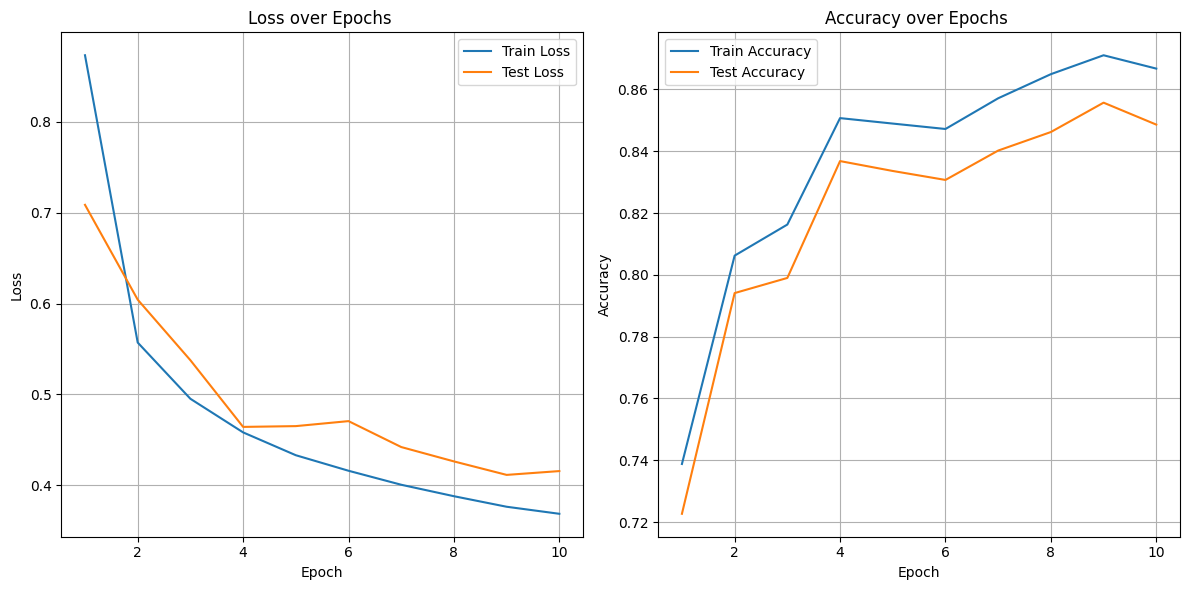

Final Test Accuracy for 2048 hidden units: 0.8486

Training with num_hiddens = 4096
Epoch 1: train_loss=0.8186, test_loss=0.6458, train_acc=0.7862, test_acc=0.7775
Epoch 2: train_loss=0.5388, test_loss=0.5243, train_acc=0.8280, test_acc=0.8155
Epoch 3: train_loss=0.4810, test_loss=0.5124, train_acc=0.8277, test_acc=0.8120
Epoch 4: train_loss=0.4458, test_loss=0.5355, train_acc=0.8226, test_acc=0.8067
Epoch 5: train_loss=0.4262, test_loss=0.5713, train_acc=0.7962, test_acc=0.7742
Epoch 6: train_loss=0.4080, test_loss=0.4666, train_acc=0.8487, test_acc=0.8359
Epoch 7: train_loss=0.3923, test_loss=0.4352, train_acc=0.8623, test_acc=0.8463
Epoch 8: train_loss=0.3797, test_loss=0.4270, train_acc=0.8624, test_acc=0.8470
Epoch 9: train_loss=0.3677, test_loss=0.4134, train_acc=0.8678, test_acc=0.8522
Epoch 10: train_loss=0.3593, test_loss=0.4059, train_acc=0.8711, test_acc=0.8532


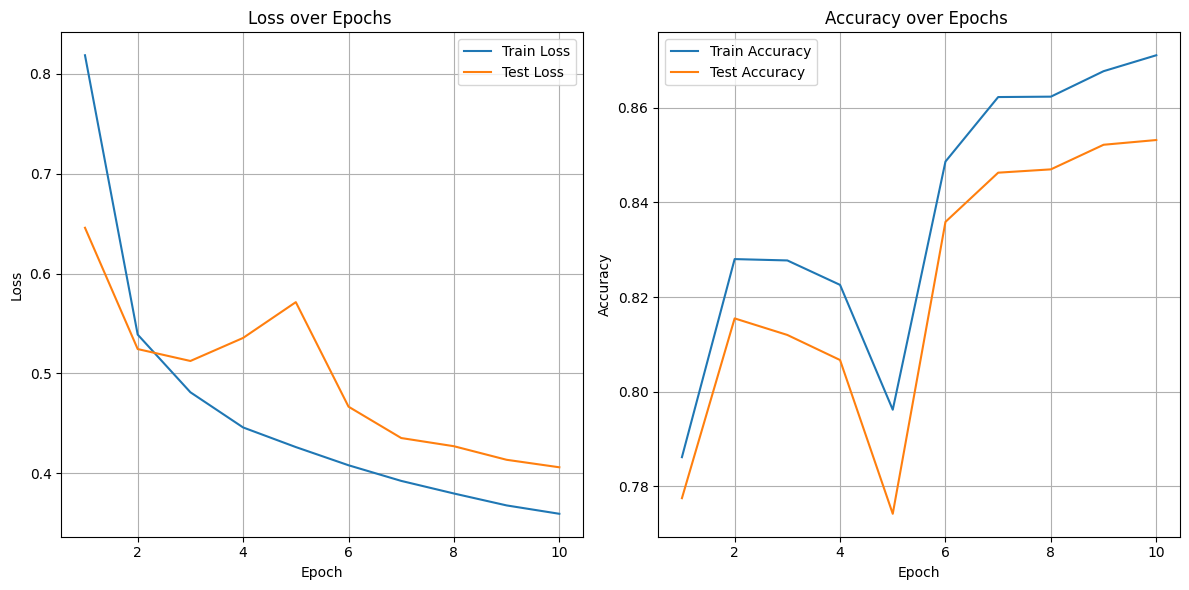

Final Test Accuracy for 4096 hidden units: 0.8532

Training with num_hiddens = 8192
Epoch 1: train_loss=0.7605, test_loss=0.6062, train_acc=0.7992, test_acc=0.7881
Epoch 2: train_loss=0.5189, test_loss=0.7326, train_acc=0.7383, test_acc=0.7220
Epoch 3: train_loss=0.4698, test_loss=0.4957, train_acc=0.8372, test_acc=0.8221
Epoch 4: train_loss=0.4346, test_loss=0.4516, train_acc=0.8538, test_acc=0.8415
Epoch 5: train_loss=0.4153, test_loss=0.4926, train_acc=0.8316, test_acc=0.8173
Epoch 6: train_loss=0.3947, test_loss=0.4238, train_acc=0.8658, test_acc=0.8495
Epoch 7: train_loss=0.3782, test_loss=0.4055, train_acc=0.8707, test_acc=0.8549
Epoch 8: train_loss=0.3683, test_loss=0.4049, train_acc=0.8740, test_acc=0.8568
Epoch 9: train_loss=0.3577, test_loss=0.4180, train_acc=0.8673, test_acc=0.8477
Epoch 10: train_loss=0.3503, test_loss=0.4012, train_acc=0.8757, test_acc=0.8551


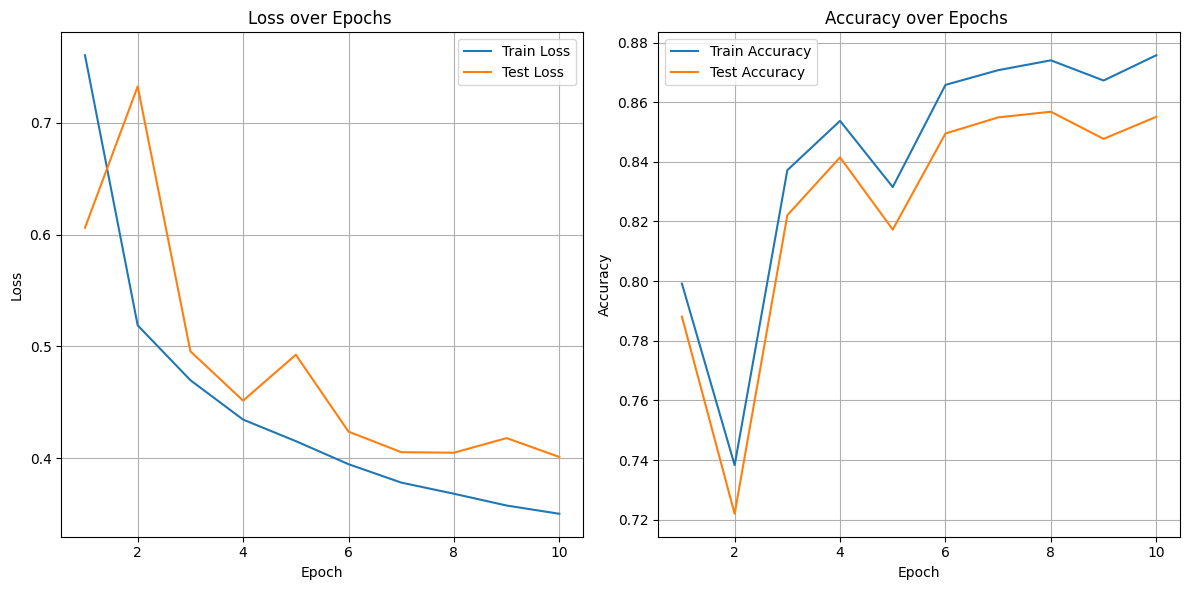

Final Test Accuracy for 8192 hidden units: 0.8551


In [24]:
num_hiddens = gen_logrithm_nums(initial_value=64, growth_factor=2, num_elements=8)
final_test_accuracies = []
best_accuracy = 0.0
best_num_hiddens = 0

for num_hidden in num_hiddens:
    print(f"\nTraining with num_hiddens = {num_hidden}")
    num_epochs, train_losses, test_losses, train_accs, test_accs = train_model(num_inputs, num_hidden, num_outputs, learning_rate, sigma)
    show_training_graphs(num_epochs, train_losses, test_losses, train_accs, test_accs)
    final_test_accuracies.append(test_accs[-1])
    print(f"Final Test Accuracy for {num_hidden} hidden units: {test_accs[-1]:.4f}")
    if test_accs[-1] > best_accuracy:
        best_accuracy = test_accs[-1]
        best_num_hiddens = num_hidden

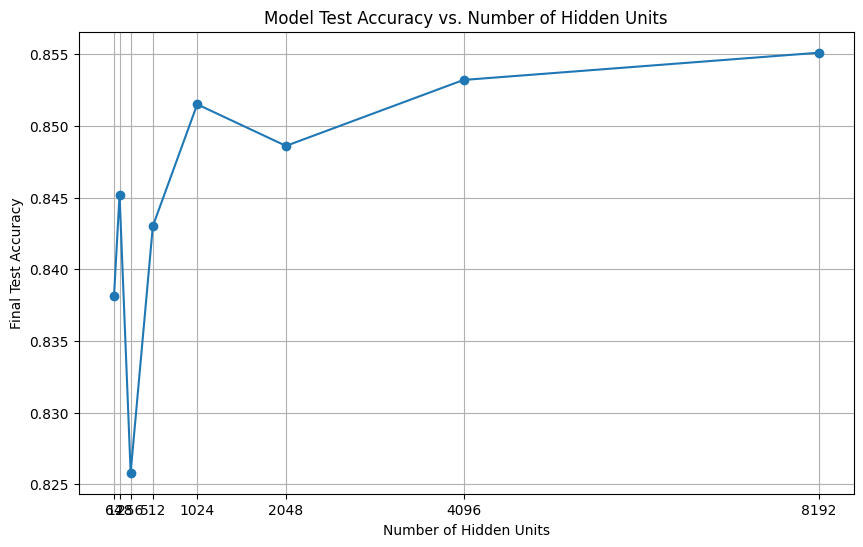

In [25]:
# Vẽ đồ thị
plt.figure(figsize=(10, 6))
plt.plot(num_hiddens, final_test_accuracies, marker='o', linestyle='-')
plt.title('Model Test Accuracy vs. Number of Hidden Units')
plt.xlabel('Number of Hidden Units')
plt.ylabel('Final Test Accuracy')
plt.xticks(num_hiddens)
plt.grid(True)

*   Thay đổi số neuron trong một lớp ẩn có thể cho độ chính xác tốt hơn, nhưng tốn tài nguyên nếu số nueron tăng

Ta có công thức tính số lượng parameter n lớp ẩn:
$$Parameters=i * h1 + \sum_{k=1}^{n-1}(h_k * h_{k+1}) + h_n * o + \sum_{k=1}^n h_k + o$$
Công thức tính số lượng parameter 1 lớp ẩn:
$$Parameters=(i * h) + h + (h * o) + o$$
trong đó $h$ là num_hiddens, $i$ và $o$ lần lượt là số nueron đầu vào và đầu ra. Khi $h$ tăng, số lượng parameter tăng tuyến tính với $h$, dẫn đến khả năng biểu diễn phức tạp hơn (do kích thước tập huấn luyện và độ phức tạp của dữ liệu tăng) cũng như tốn tài nguyên hơn.

### 2: Try adding a hidden layer to see how it affects the results.

In [18]:
def init_params_n_hidden_layer(layer_dims, sigma=0.01):
    params = {}
    L = len(layer_dims) - 1 # Tổng số lớp có trọng số (hidden + output)

    for l in range(1, L + 1):
        params['W' + str(l)] = np.random.randn(layer_dims[l-1], layer_dims[l]) * sigma
        params['b' + str(l)] = np.zeros((1, layer_dims[l]))
    return params

In [19]:
def forward_propagation_n_hidden_layer(X, params, num_total_layers):
    cache_A = {0: X} # A0 là X
    cache_Z = {}
    A_curr = X

    # Lớp ẩn (ReLU)
    for l in range(1, num_total_layers): # l từ 1 đến L-1
        Wl = params['W' + str(l)]
        bl = params['b' + str(l)]
        Zl = A_curr.dot(Wl) + bl
        A_curr = relu(Zl)
        cache_Z[l] = Zl
        cache_A[l] = A_curr

    # Lớp đầu ra (Softmax) - lớp L
    WL = params['W' + str(num_total_layers)]
    bL = params['b' + str(num_total_layers)]
    ZL = A_curr.dot(WL) + bL
    Y_hat = softmax(ZL)
    cache_Z[num_total_layers] = ZL
    cache_A[num_total_layers] = Y_hat # AL là Y_hat

    return Y_hat, (cache_A, cache_Z)

In [20]:
def backward_propagation_n_hidden_layers(X, Y, Y_hat, cache, params, num_total_layers):
    cache_A, cache_Z = cache
    grads = {}
    loss_val, dZ_curr = cross_entropy_loss(Y_hat, Y) # dZL là gradient của loss w.r.t Z của lớp output

    for l_idx in range(num_total_layers, 0, -1): # L, L-1, ..., 1
        A_prev = cache_A[l_idx-1] # Activation ở lớp ẩn phía trước (A0 là X ở l_idx=1)
        Wl = params['W' + str(l_idx)]

        # Gradients cho Wl and bl
        grads['dW' + str(l_idx)] = A_prev.T.dot(dZ_curr)
        grads['db' + str(l_idx)] = np.sum(dZ_curr, axis=0, keepdims=True)

        # Tính dZ cho lớp ẩn phía trước, nếu không phải là lớp đầu vào
        if l_idx > 1:
            dA_prev = dZ_curr.dot(Wl.T) # Gradient w.r.t. activation of previous layer (A_{l-1})
            Z_prev = cache_Z[l_idx-1]   # Z value of the previous layer (Z_{l-1})
            dZ_curr = dA_prev * relu_derivative(Z_prev) # Gradient w.r.t. Z of previous layer

    return grads

def update_params_n_hidden_layers(params, grads, learning_rate, num_total_layers):
    for l in range(1, num_total_layers + 1):
        params['W' + str(l)] -= learning_rate * grads['dW' + str(l)]
        params['b' + str(l)] -= learning_rate * grads['db' + str(l)]

In [21]:
def evaluate_accuracy_n_hidden_layers(data_loader, params, layer_dims):
    correct = total = 0
    num_total_layers = len(layer_dims) - 1
    num_inputs = layer_dims[0]
    for X_t, y_t in data_loader:
        X_np = X_t.numpy().reshape(-1, num_inputs)
        Y_hat, _ = forward_propagation_n_hidden_layer(X_np, params, num_total_layers)
        y_pred = np.argmax(Y_hat, axis=1)
        correct += np.sum(y_pred == y_t.numpy())
        total += y_t.shape[0]
    return correct / total

def evaluate_loss_n_hidden_layers(data_loader, params, layer_dims):
    total_loss = 0.0
    total_samples = 0
    num_total_layers = len(layer_dims) - 1
    num_inputs = layer_dims[0]
    for X_t, y_t in data_loader:
        X_np = X_t.numpy().reshape(-1, num_inputs)
        Y_hat, _ = forward_propagation_n_hidden_layer(X_np, params, num_total_layers)
        loss, _ = cross_entropy_loss(Y_hat, y_t.numpy())
        total_loss += loss * X_np.shape[0]
        total_samples += X_np.shape[0]
    return total_loss / total_samples

In [22]:
def train_model_n_hidden_layers(layer_dims, learning_rate=0.1, sigma=0.01, num_epochs=10):
    params = init_params_n_hidden_layer(layer_dims, sigma)
    num_total_layers = len(layer_dims) - 1
    num_inputs = layer_dims[0]

    train_losses = []
    test_losses = []
    train_accs = []
    test_accs = []

    print(f"Starting training with architecture: {layer_dims}")
    for epoch in range(1, num_epochs + 1):
        epoch_train_loss = 0.0
        for X_batch_t, y_batch_t in train_loader:
            # Chuyển sang numpy
            X_batch_np = X_batch_t.numpy().reshape(-1, num_inputs)
            y_batch_np = y_batch_t.numpy()

            # Forward propagation
            Y_hat, cache = forward_propagation_n_hidden_layer(X_batch_np, params, num_total_layers)

            # Tính loss (dZ cho output layer thì cũng được tiinhs trong cross_entropy_loss)
            current_loss, _ = cross_entropy_loss(Y_hat, y_batch_np)
            epoch_train_loss += current_loss * X_batch_np.shape[0]

            # Backward propagation
            grads = backward_propagation_n_hidden_layers(X_batch_np, y_batch_np, Y_hat, cache, params, num_total_layers)

            # Cập nhật parameters
            update_params_n_hidden_layers(params, grads, learning_rate, num_total_layers)

        # Evaluate and store metrics for the epoch
        avg_epoch_train_loss = epoch_train_loss / len(train_ds)
        train_losses.append(avg_epoch_train_loss)

        current_test_loss = evaluate_loss_n_hidden_layers(test_loader, params, layer_dims)
        test_losses.append(current_test_loss)

        current_train_acc = evaluate_accuracy_n_hidden_layers(train_loader, params, layer_dims)
        train_accs.append(current_train_acc)

        current_test_acc = evaluate_accuracy_n_hidden_layers(test_loader, params, layer_dims)
        test_accs.append(current_test_acc)

        print(f"Epoch {epoch}/{num_epochs}: "
              f"train_loss={avg_epoch_train_loss:.4f}, "
              f"test_loss={current_test_loss:.4f}, "
              f"train_acc={current_train_acc:.4f}, "
              f"test_acc={current_test_acc:.4f}")

    return num_epochs, train_losses, test_losses, train_accs, test_accs, params

*   Implement MLP với 2 lớp ẩn


In [23]:
layer_dimensions  = [784, 256, 128, 10]
trained_epochs, t_losses, v_losses, t_accs, v_accs, trained_params = train_model_n_hidden_layers(
        layer_dims=layer_dimensions,
        learning_rate=learning_rate,
        sigma=sigma,
        num_epochs=num_epochs
    )

Starting training with architecture: [784, 256, 128, 10]
Epoch 1/10: train_loss=1.8266, test_loss=1.1779, train_acc=0.5058, test_acc=0.4998
Epoch 2/10: train_loss=0.9201, test_loss=0.8138, train_acc=0.7033, test_acc=0.6964
Epoch 3/10: train_loss=0.6962, test_loss=0.6696, train_acc=0.7432, test_acc=0.7352
Epoch 4/10: train_loss=0.5937, test_loss=0.5900, train_acc=0.7915, test_acc=0.7846
Epoch 5/10: train_loss=0.5375, test_loss=0.6073, train_acc=0.7915, test_acc=0.7755
Epoch 6/10: train_loss=0.4929, test_loss=0.5020, train_acc=0.8331, test_acc=0.8185
Epoch 7/10: train_loss=0.4594, test_loss=0.6075, train_acc=0.7810, test_acc=0.7650
Epoch 8/10: train_loss=0.4398, test_loss=0.5019, train_acc=0.8296, test_acc=0.8131
Epoch 9/10: train_loss=0.4192, test_loss=0.4913, train_acc=0.8329, test_acc=0.8129
Epoch 10/10: train_loss=0.3993, test_loss=0.4506, train_acc=0.8472, test_acc=0.8356


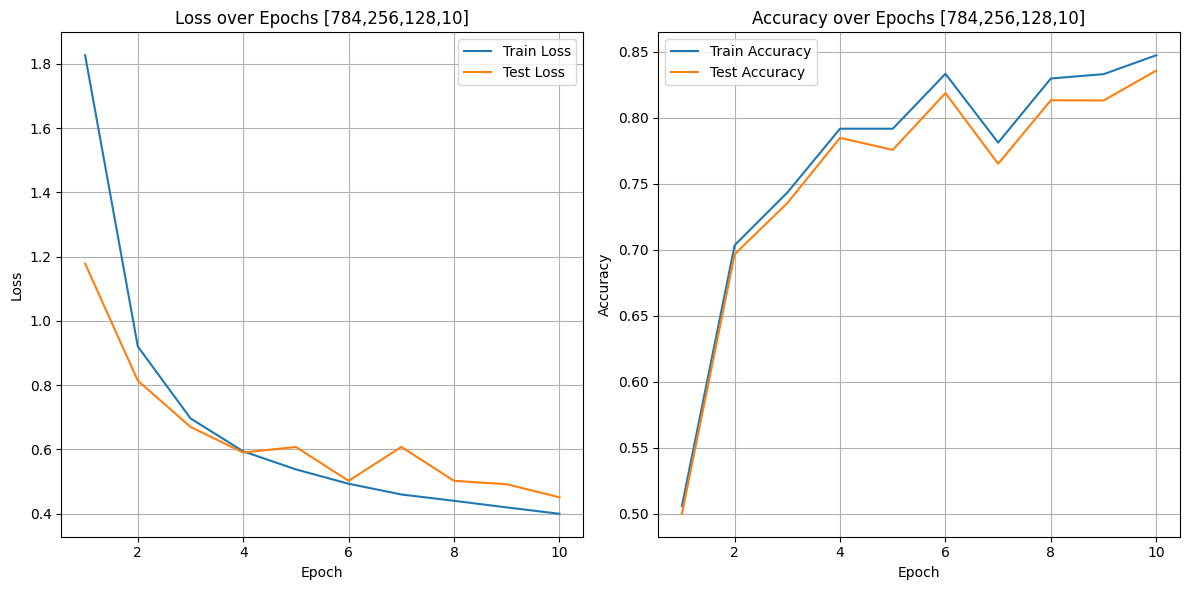

In [24]:
layer_dims_for_plot = str(layer_dimensions).replace(" ","")
show_training_graphs(trained_epochs, t_losses, v_losses, t_accs, v_accs, layer_dims_str=layer_dims_for_plot)

*   Implement với 3 lớp ẩn

In [25]:
layer_dimensions  = [784, 256, 128, 64, 10]
trained_epochs, t_losses, v_losses, t_accs, v_accs, trained_params = train_model_n_hidden_layers(
        layer_dims=layer_dimensions,
        learning_rate=learning_rate,
        sigma=sigma,
        num_epochs=num_epochs
    )

Starting training with architecture: [784, 256, 128, 64, 10]
Epoch 1/10: train_loss=2.3027, test_loss=2.3025, train_acc=0.1000, test_acc=0.1000
Epoch 2/10: train_loss=2.3025, test_loss=2.3023, train_acc=0.1000, test_acc=0.1000
Epoch 3/10: train_loss=2.3016, test_loss=2.2993, train_acc=0.1799, test_acc=0.1810
Epoch 4/10: train_loss=1.9782, test_loss=1.3805, train_acc=0.4050, test_acc=0.4029
Epoch 5/10: train_loss=1.3061, test_loss=1.0680, train_acc=0.5493, test_acc=0.5470
Epoch 6/10: train_loss=1.0086, test_loss=0.9033, train_acc=0.6519, test_acc=0.6487
Epoch 7/10: train_loss=0.8586, test_loss=0.8648, train_acc=0.6923, test_acc=0.6932
Epoch 8/10: train_loss=0.6995, test_loss=0.6737, train_acc=0.7801, test_acc=0.7689
Epoch 9/10: train_loss=0.6246, test_loss=0.7419, train_acc=0.7079, test_acc=0.7028
Epoch 10/10: train_loss=0.5745, test_loss=0.5756, train_acc=0.8073, test_acc=0.7939


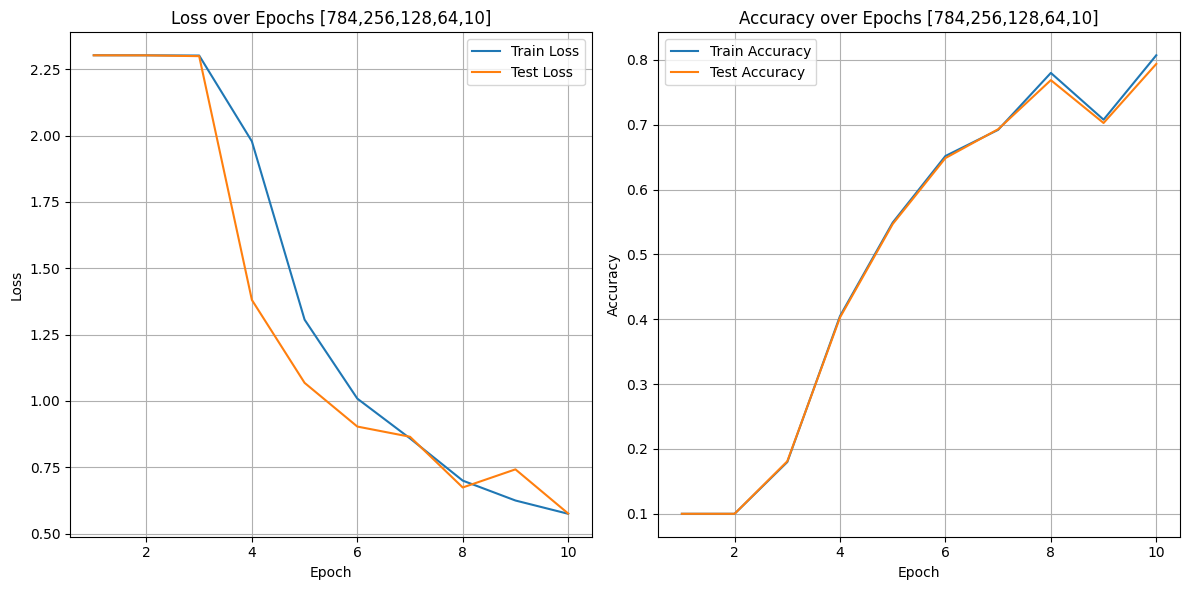

In [26]:
layer_dims_for_plot = str(layer_dimensions).replace(" ","")
show_training_graphs(trained_epochs, t_losses, v_losses, t_accs, v_accs, layer_dims_str=layer_dims_for_plot)

*   Implement với 4 lớp ẩn

In [27]:
layer_dimensions  = [784, 512, 256, 128, 64, 10]
trained_epochs, t_losses, v_losses, t_accs, v_accs, trained_params = train_model_n_hidden_layers(
        layer_dims=layer_dimensions,
        learning_rate=learning_rate,
        sigma=sigma,
        num_epochs=num_epochs
    )

Starting training with architecture: [784, 512, 256, 128, 64, 10]
Epoch 1/10: train_loss=2.3027, test_loss=2.3026, train_acc=0.1000, test_acc=0.1000
Epoch 2/10: train_loss=2.3027, test_loss=2.3026, train_acc=0.1000, test_acc=0.1000
Epoch 3/10: train_loss=2.3027, test_loss=2.3026, train_acc=0.1000, test_acc=0.1000
Epoch 4/10: train_loss=2.3027, test_loss=2.3026, train_acc=0.1000, test_acc=0.1000
Epoch 5/10: train_loss=2.3027, test_loss=2.3026, train_acc=0.1000, test_acc=0.1000
Epoch 6/10: train_loss=2.3027, test_loss=2.3026, train_acc=0.1000, test_acc=0.1000
Epoch 7/10: train_loss=2.3027, test_loss=2.3026, train_acc=0.1000, test_acc=0.1000
Epoch 8/10: train_loss=2.3027, test_loss=2.3026, train_acc=0.1000, test_acc=0.1000
Epoch 9/10: train_loss=2.3027, test_loss=2.3026, train_acc=0.1000, test_acc=0.1000
Epoch 10/10: train_loss=2.3027, test_loss=2.3025, train_acc=0.1000, test_acc=0.1000


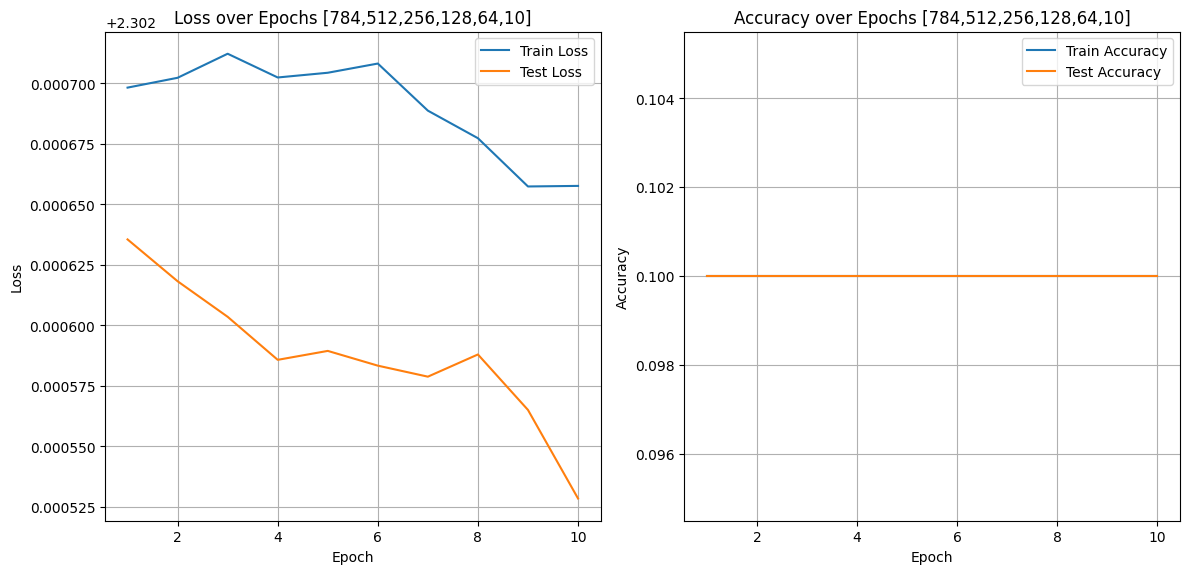

In [28]:
layer_dims_for_plot = str(layer_dimensions).replace(" ","")
show_training_graphs(trained_epochs, t_losses, v_losses, t_accs, v_accs, layer_dims_str=layer_dims_for_plot)

Tăng số lớp ẩn có thể cho độ chính xác tốt hơn. Nhưng tăng quá nhiều lớp dễ đẫn đến overfitting và tốn tài nguyên.

### 3: Why is it a bad idea to insert a hidden layer with a single neuron? What could go wrong?
Việc thêm một lớp ẩn chỉ với một neuron duy nhất vào một MLP thường là một ý tưởng không tốt vì nó tạo ra một "Bottleneck" nghiêm trọng về thông tin và hạn chế đáng kể khả năng biểu diễn của mạng. Lớp này sẽ nén toàn bộ thông tin đầu vào thành một giá trị duy nhất, khiến mạng không thể học được các đặc trưng phức tạp trong dữ liệu. \
Trong một MLP, các lớp ẩn được thiết kế để học các biểu diễn trung gian, phi tuyến của dữ liệu đầu vào. Các neuron trong lớp ẩn kết hợp các tín hiệu từ lớp trước đó và áp dụng một hàm kích hoạt (thường là phi tuyến như ReLU, sigmoid, tanh) để tạo ra các đặc trưng mới. Những đặc trưng này sau đó được sử dụng bởi các lớp tiếp theo để thực hiện nhiệm vụ (ví dụ: phân loại hoặc hồi quy). Số lượng neuron trong một lớp ẩn thường liên quan đến độ phức tạp của các hàm mà mạng có thể học
*   Giảm chiều dữ liệu xuống 1: \
Một lớp ẩn với 1 neuron sẽ biến mọi đầu vào (dù có nhiều chiều) thành một số duy nhất. Như vậy, mọi thông tin phân biệt giữa các điểm dữ liệu chỉ còn lại trên một trục số, khiến mạng chỉ có thể học các ranh giới quyết định tuyến tính (một đường thẳng trên trục số).
*   Không đủ khả năng phân biệt: \
Nếu đầu vào phức tạp, ví dụ như hình ảnh hoặc dữ liệu nhiều chiều, việc nén toàn bộ xuống 1 chiều sẽ làm mất mát thông tin quan trọng. Mạng sẽ không thể phân biệt được các mẫu dữ liệu có đặc trưng khác nhau nhưng lại có cùng giá trị sau khi qua lớp 1 neuron này.
*   Giới hạn khả năng mô hình hóa: \
Mỗi neuron trong lớp ẩn giống như một bộ lọc đặc trưng. Nếu chỉ có 1 neuron, mạng chỉ học được một đặc trưng duy nhất. Để mô hình hóa các quan hệ phi tuyến tính phức tạp, cần nhiều neuron để tạo ra nhiều đặc trưng khác nhau \




*   Implement 1 lớp ẩn với 1 neron

In [29]:
layer_dimensions  = [784, 1, 10]
# num_epochs        = 20
trained_epochs, t_losses, v_losses, t_accs, v_accs, trained_params = train_model_n_hidden_layers(
        layer_dims=layer_dimensions,
        learning_rate=learning_rate,
        sigma=sigma,
        num_epochs=num_epochs
    )

Starting training with architecture: [784, 1, 10]
Epoch 1/10: train_loss=1.9558, test_loss=1.7517, train_acc=0.2348, test_acc=0.2343
Epoch 2/10: train_loss=1.6866, test_loss=1.6472, train_acc=0.3105, test_acc=0.3108
Epoch 3/10: train_loss=1.6144, test_loss=1.6092, train_acc=0.2948, test_acc=0.2962
Epoch 4/10: train_loss=1.5756, test_loss=1.5856, train_acc=0.2948, test_acc=0.2949
Epoch 5/10: train_loss=1.5494, test_loss=1.5445, train_acc=0.3459, test_acc=0.3457
Epoch 6/10: train_loss=1.5298, test_loss=1.5202, train_acc=0.3538, test_acc=0.3551
Epoch 7/10: train_loss=1.5142, test_loss=1.5193, train_acc=0.3361, test_acc=0.3411
Epoch 8/10: train_loss=1.5022, test_loss=1.5175, train_acc=0.3385, test_acc=0.3369
Epoch 9/10: train_loss=1.4909, test_loss=1.4988, train_acc=0.3453, test_acc=0.3451
Epoch 10/10: train_loss=1.4826, test_loss=1.4807, train_acc=0.3723, test_acc=0.3711


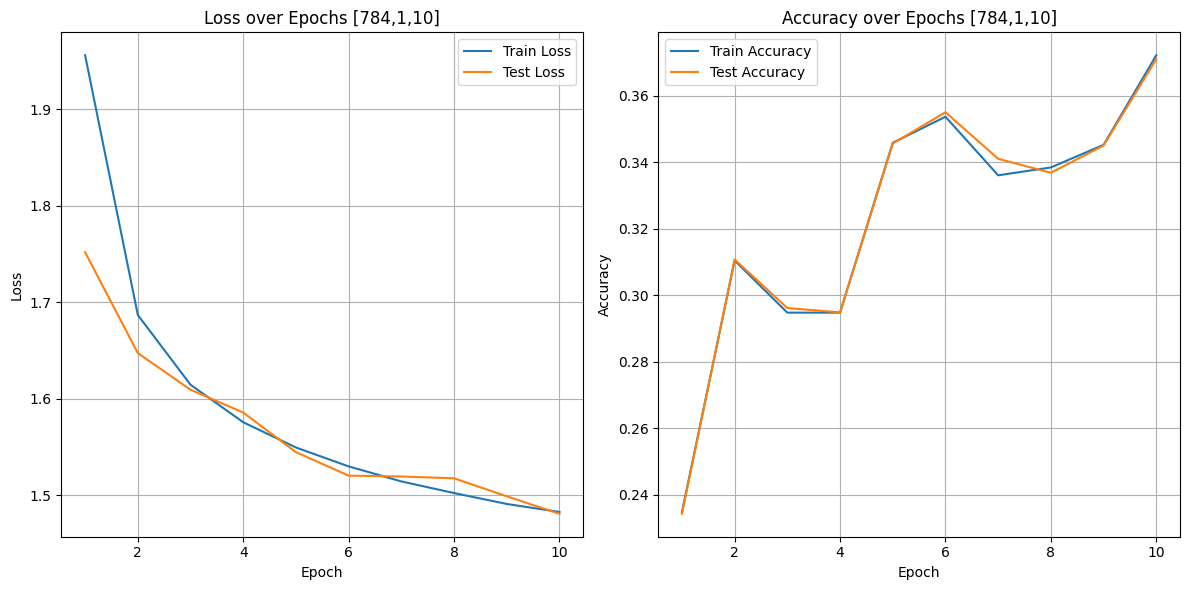

In [30]:
layer_dims_for_plot = str(layer_dimensions).replace(" ","")
show_training_graphs(trained_epochs, t_losses, v_losses, t_accs, v_accs, layer_dims_str=layer_dims_for_plot)

### 4: How does changing the learning rate alter your results? With all other parameters fixed, which learning rate gives you the best results? How does this relate to the number of epochs?


Training with learning_rate = 0.001
Starting training with architecture: [784, 256, 10]
Epoch 1/10: train_loss=2.2932, test_loss=2.2852, train_acc=0.2545, test_acc=0.2522
Epoch 2/10: train_loss=2.2764, test_loss=2.2672, train_acc=0.2569, test_acc=0.2539
Epoch 3/10: train_loss=2.2561, test_loss=2.2444, train_acc=0.2543, test_acc=0.2521
Epoch 4/10: train_loss=2.2300, test_loss=2.2146, train_acc=0.2649, test_acc=0.2596
Epoch 5/10: train_loss=2.1958, test_loss=2.1761, train_acc=0.3115, test_acc=0.3039
Epoch 6/10: train_loss=2.1523, test_loss=2.1278, train_acc=0.3953, test_acc=0.3853
Epoch 7/10: train_loss=2.0988, test_loss=2.0694, train_acc=0.4713, test_acc=0.4628
Epoch 8/10: train_loss=2.0352, test_loss=2.0013, train_acc=0.5277, test_acc=0.5190
Epoch 9/10: train_loss=1.9625, test_loss=1.9252, train_acc=0.5581, test_acc=0.5518
Epoch 10/10: train_loss=1.8835, test_loss=1.8447, train_acc=0.5753, test_acc=0.5678


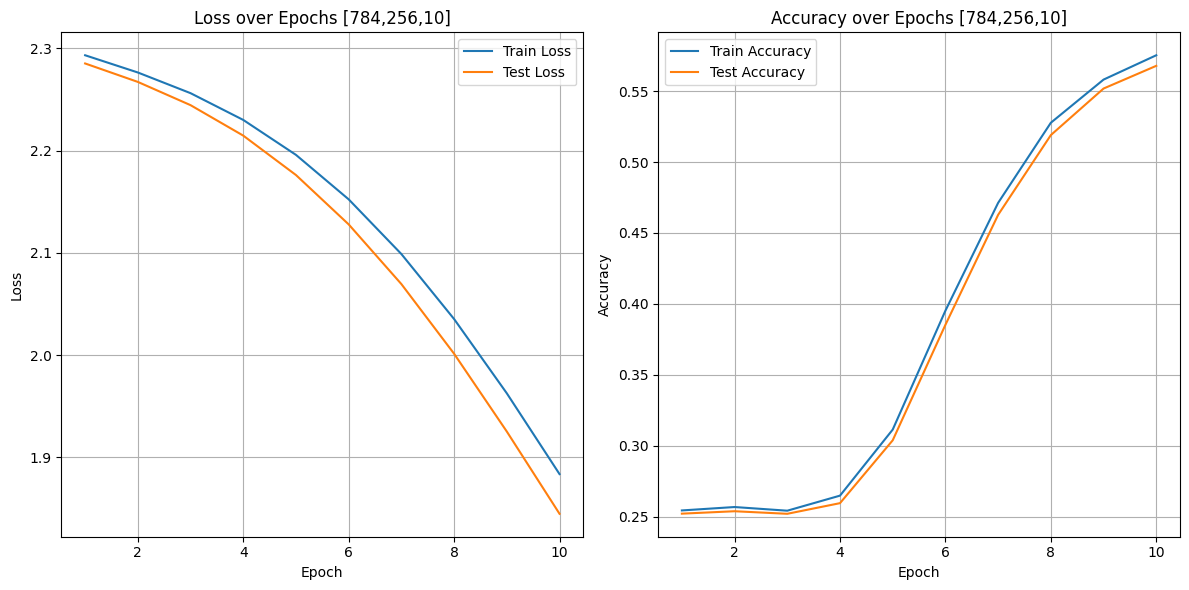

Final Test Accuracy for learning_rate 0.001: 0.5678

Training with learning_rate = 0.01
Starting training with architecture: [784, 256, 10]
Epoch 1/10: train_loss=2.1523, test_loss=1.8687, train_acc=0.4818, test_acc=0.4748
Epoch 2/10: train_loss=1.5211, test_loss=1.2632, train_acc=0.6354, test_acc=0.6284
Epoch 3/10: train_loss=1.1096, test_loss=1.0068, train_acc=0.6577, test_acc=0.6476
Epoch 4/10: train_loss=0.9280, test_loss=0.8857, train_acc=0.6767, test_acc=0.6643
Epoch 5/10: train_loss=0.8345, test_loss=0.8182, train_acc=0.7023, test_acc=0.6881
Epoch 6/10: train_loss=0.7767, test_loss=0.7696, train_acc=0.7255, test_acc=0.7135
Epoch 7/10: train_loss=0.7344, test_loss=0.7337, train_acc=0.7439, test_acc=0.7328
Epoch 8/10: train_loss=0.7000, test_loss=0.7026, train_acc=0.7610, test_acc=0.7495
Epoch 9/10: train_loss=0.6712, test_loss=0.6756, train_acc=0.7730, test_acc=0.7630
Epoch 10/10: train_loss=0.6459, test_loss=0.6528, train_acc=0.7813, test_acc=0.7711


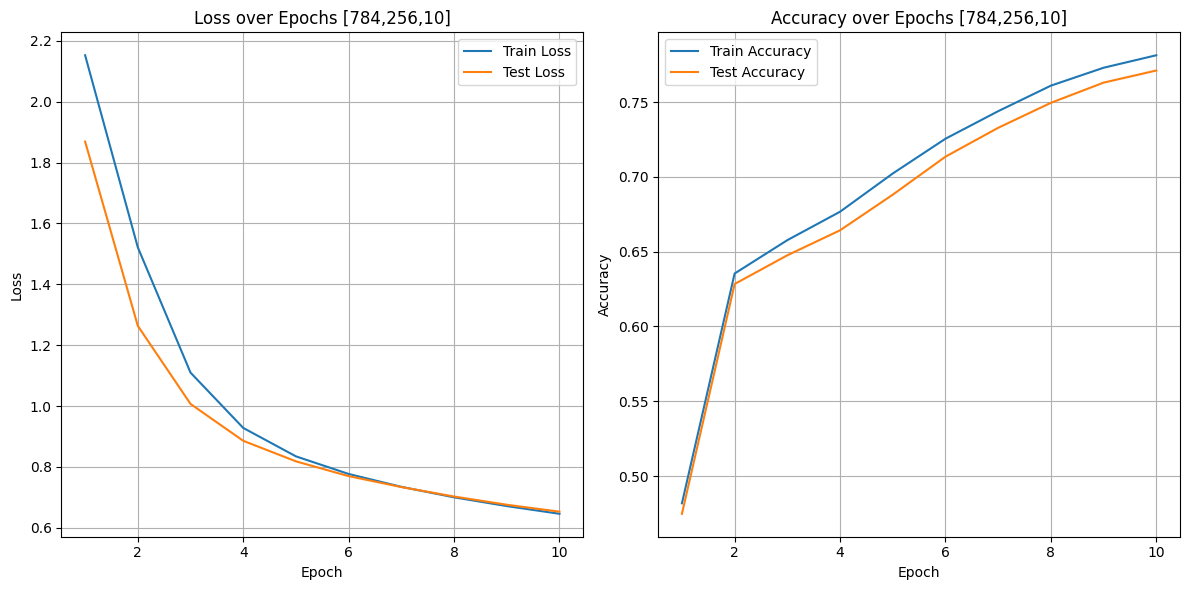

Final Test Accuracy for learning_rate 0.01: 0.7711

Training with learning_rate = 0.1
Starting training with architecture: [784, 256, 10]
Epoch 1/10: train_loss=1.0449, test_loss=0.6946, train_acc=0.7657, test_acc=0.7519
Epoch 2/10: train_loss=0.5976, test_loss=0.5671, train_acc=0.8094, test_acc=0.7987
Epoch 3/10: train_loss=0.5176, test_loss=0.6160, train_acc=0.7806, test_acc=0.7624
Epoch 4/10: train_loss=0.4832, test_loss=0.4926, train_acc=0.8359, test_acc=0.8245
Epoch 5/10: train_loss=0.4543, test_loss=0.4816, train_acc=0.8433, test_acc=0.8314
Epoch 6/10: train_loss=0.4350, test_loss=0.4812, train_acc=0.8401, test_acc=0.8269
Epoch 7/10: train_loss=0.4179, test_loss=0.4674, train_acc=0.8483, test_acc=0.8338
Epoch 8/10: train_loss=0.4041, test_loss=0.4558, train_acc=0.8504, test_acc=0.8372
Epoch 9/10: train_loss=0.3914, test_loss=0.4145, train_acc=0.8683, test_acc=0.8545
Epoch 10/10: train_loss=0.3803, test_loss=0.4201, train_acc=0.8678, test_acc=0.8515


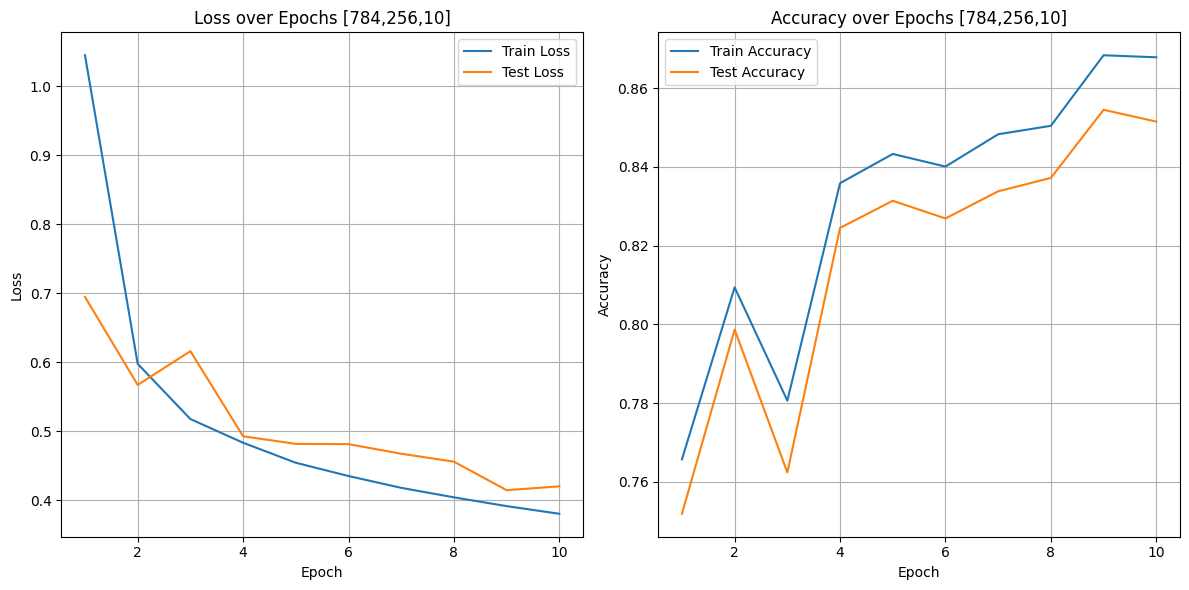

Final Test Accuracy for learning_rate 0.1: 0.8515

Training with learning_rate = 0.3
Starting training with architecture: [784, 256, 10]
Epoch 1/10: train_loss=0.8005, test_loss=0.6104, train_acc=0.7907, test_acc=0.7776
Epoch 2/10: train_loss=0.4914, test_loss=0.5989, train_acc=0.7892, test_acc=0.7725
Epoch 3/10: train_loss=0.4360, test_loss=0.4703, train_acc=0.8362, test_acc=0.8205
Epoch 4/10: train_loss=0.4038, test_loss=0.4851, train_acc=0.8373, test_acc=0.8240
Epoch 5/10: train_loss=0.3814, test_loss=0.4770, train_acc=0.8369, test_acc=0.8227
Epoch 6/10: train_loss=0.3642, test_loss=0.4383, train_acc=0.8592, test_acc=0.8433
Epoch 7/10: train_loss=0.3477, test_loss=0.4505, train_acc=0.8541, test_acc=0.8364
Epoch 8/10: train_loss=0.3379, test_loss=0.4278, train_acc=0.8568, test_acc=0.8346
Epoch 9/10: train_loss=0.3237, test_loss=0.4085, train_acc=0.8624, test_acc=0.8423
Epoch 10/10: train_loss=0.3169, test_loss=0.3849, train_acc=0.8795, test_acc=0.8651


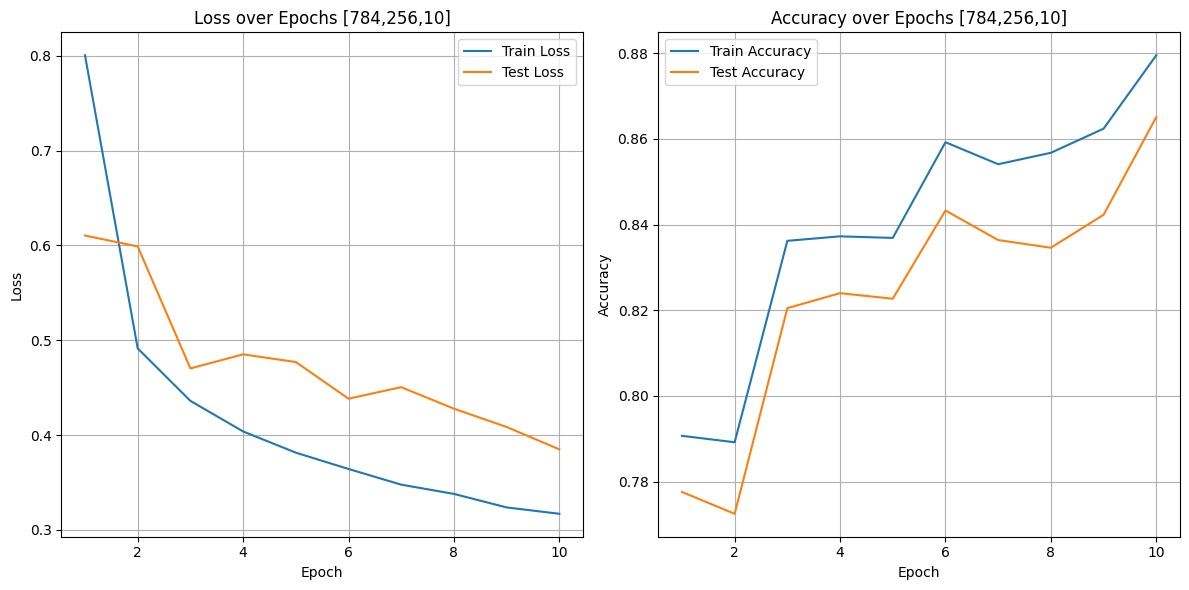

Final Test Accuracy for learning_rate 0.3: 0.8651

Training with learning_rate = 0.5
Starting training with architecture: [784, 256, 10]
Epoch 1/10: train_loss=0.7785, test_loss=0.8423, train_acc=0.7395, test_acc=0.7318
Epoch 2/10: train_loss=0.4894, test_loss=0.6581, train_acc=0.7903, test_acc=0.7750
Epoch 3/10: train_loss=0.4259, test_loss=0.4929, train_acc=0.8380, test_acc=0.8253
Epoch 4/10: train_loss=0.3863, test_loss=0.4365, train_acc=0.8596, test_acc=0.8424
Epoch 5/10: train_loss=0.3667, test_loss=0.4470, train_acc=0.8510, test_acc=0.8366
Epoch 6/10: train_loss=0.3456, test_loss=0.4723, train_acc=0.8429, test_acc=0.8265
Epoch 7/10: train_loss=0.3339, test_loss=0.4495, train_acc=0.8525, test_acc=0.8325
Epoch 8/10: train_loss=0.3185, test_loss=0.3882, train_acc=0.8788, test_acc=0.8571
Epoch 9/10: train_loss=0.3094, test_loss=0.3668, train_acc=0.8904, test_acc=0.8674
Epoch 10/10: train_loss=0.2994, test_loss=0.3663, train_acc=0.8871, test_acc=0.8678


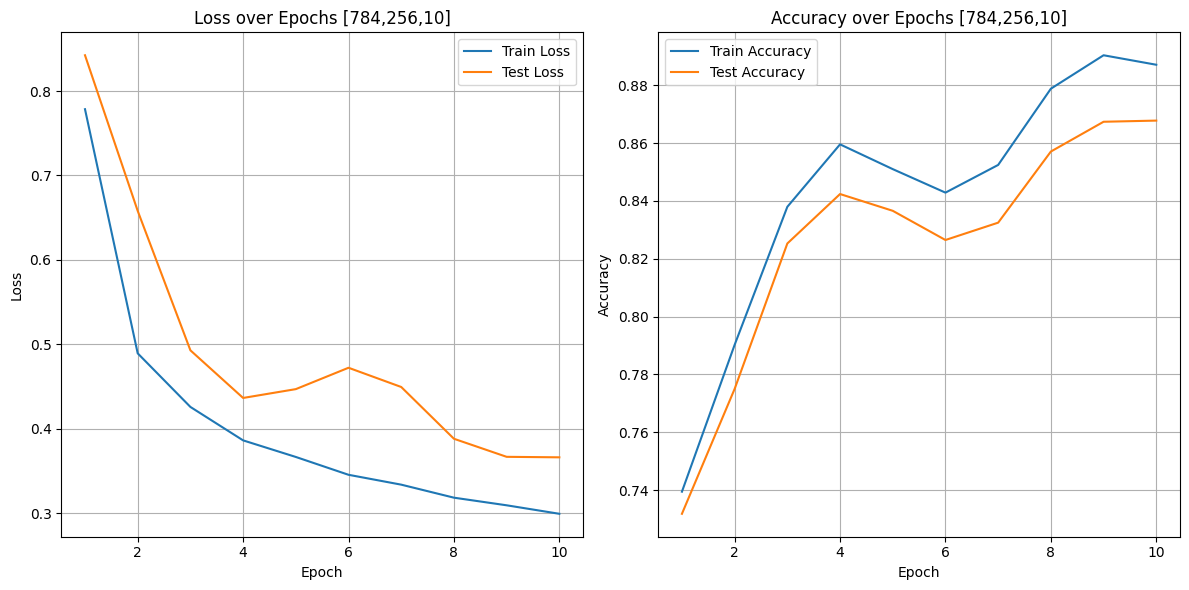

Final Test Accuracy for learning_rate 0.5: 0.8678

Training with learning_rate = 1
Starting training with architecture: [784, 256, 10]
Epoch 1/10: train_loss=2.0822, test_loss=1.6461, train_acc=0.3651, test_acc=0.3655
Epoch 2/10: train_loss=1.7796, test_loss=1.4991, train_acc=0.3720, test_acc=0.3724
Epoch 3/10: train_loss=1.5683, test_loss=1.4921, train_acc=0.3718, test_acc=0.3710
Epoch 4/10: train_loss=1.8324, test_loss=1.6679, train_acc=0.2655, test_acc=0.2654
Epoch 5/10: train_loss=1.9859, test_loss=2.0654, train_acc=0.1439, test_acc=0.1467
Epoch 6/10: train_loss=1.9259, test_loss=1.8820, train_acc=0.2575, test_acc=0.2583
Epoch 7/10: train_loss=2.0148, test_loss=2.2983, train_acc=0.2056, test_acc=0.2093
Epoch 8/10: train_loss=1.8284, test_loss=1.5864, train_acc=0.3014, test_acc=0.3021
Epoch 9/10: train_loss=2.0151, test_loss=2.3113, train_acc=0.1082, test_acc=0.1087
Epoch 10/10: train_loss=2.0112, test_loss=2.2743, train_acc=0.1908, test_acc=0.1884


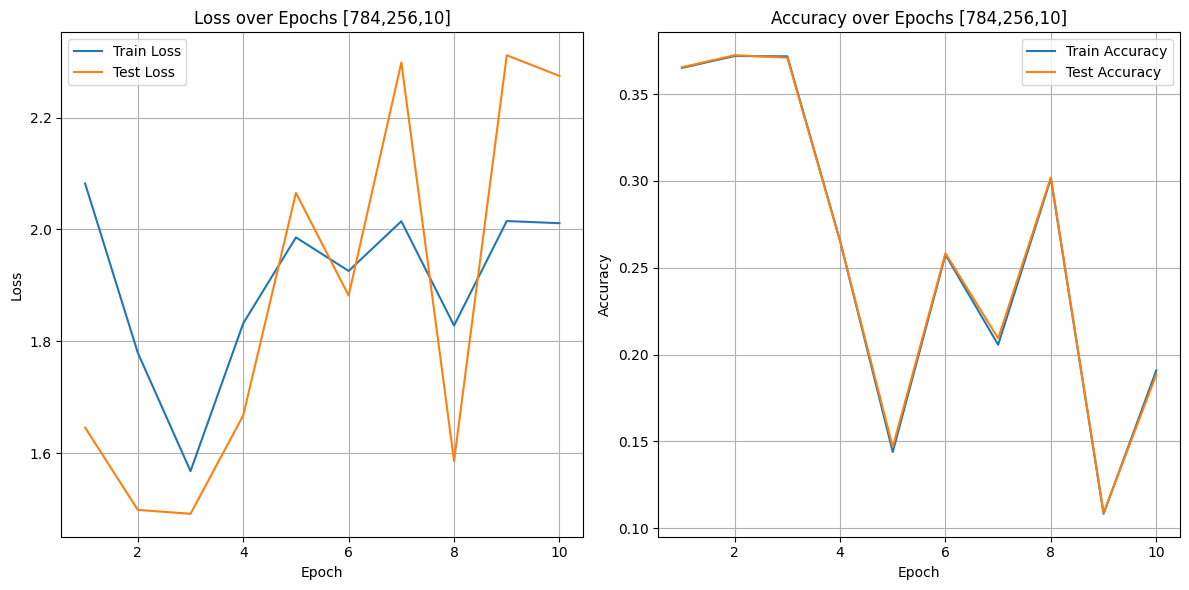

Final Test Accuracy for learning_rate 1: 0.1884


In [31]:
lrs = [0.001, 0.01, 0.1, 0.3, 0.5, 1]
layer_dimensions  = [784, 256, 10]
num_epochs        = 10

final_test_accuracies = []
best_accuracy = 0.0
best_num_hiddens = 0

for learning_rate in lrs:
  print(f"\nTraining with learning_rate = {learning_rate}")
  trained_epochs, t_losses, v_losses, t_accs, v_accs, trained_params = train_model_n_hidden_layers(
          layer_dims=layer_dimensions,
          learning_rate=learning_rate,
          sigma=sigma,
          num_epochs=num_epochs
      )
  layer_dims_for_plot = str(layer_dimensions).replace(" ","")
  show_training_graphs(trained_epochs, t_losses, v_losses, t_accs, v_accs, layer_dims_str=layer_dims_for_plot)
  final_test_accuracies.append(v_accs[-1])
  print(f"Final Test Accuracy for learning_rate {learning_rate}: {v_accs[-1]:.4f}")
  if v_accs[-1] > best_accuracy:
      best_accuracy = v_accs[-1]
      best_num_hiddens = num_hidden

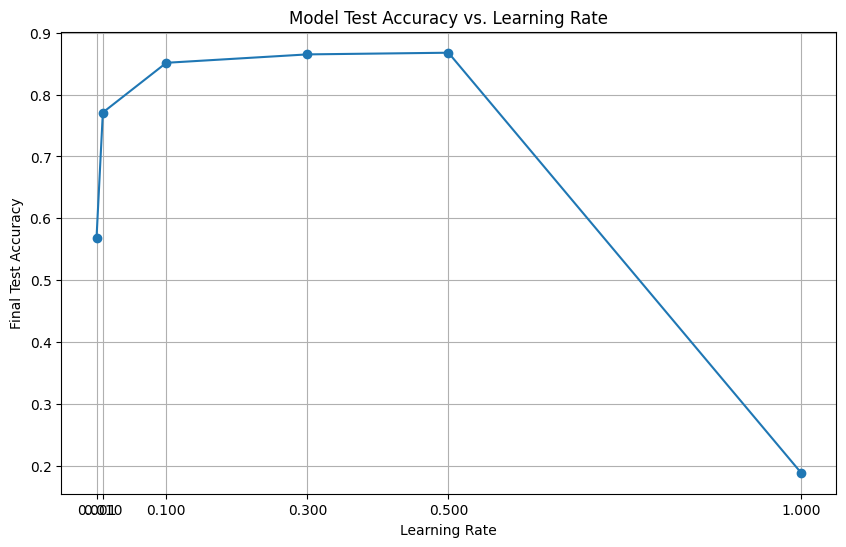

In [32]:
# Vẽ đồ thị
plt.figure(figsize=(10, 6))
plt.plot(lrs, final_test_accuracies, marker='o', linestyle='-')
plt.title('Model Test Accuracy vs. Learning Rate')
plt.xlabel('Learning Rate')
plt.ylabel('Final Test Accuracy')
plt.xticks(lrs)
plt.grid(True)

*   Khi learning rate thay đổi:
  *   Độ chính xác của mô hình cũng thay đổi. Độ chính xác tăng giai đoạn đầu, sau đó giảm khi độ ổn đinh giảm.  
  *   Độ ổn định giảm mạnh khi learning rate tăng cao.

*   Tăng num_epochs lên 20


Training with learning_rate = 0.001
Starting training with architecture: [784, 256, 10]
Epoch 1/20: train_loss=2.2958, test_loss=2.2883, train_acc=0.2218, test_acc=0.2215
Epoch 2/20: train_loss=2.2803, test_loss=2.2716, train_acc=0.2884, test_acc=0.2846
Epoch 3/20: train_loss=2.2615, test_loss=2.2504, train_acc=0.3263, test_acc=0.3207
Epoch 4/20: train_loss=2.2371, test_loss=2.2225, train_acc=0.3445, test_acc=0.3391
Epoch 5/20: train_loss=2.2049, test_loss=2.1859, train_acc=0.3646, test_acc=0.3587
Epoch 6/20: train_loss=2.1633, test_loss=2.1393, train_acc=0.4010, test_acc=0.3928
Epoch 7/20: train_loss=2.1110, test_loss=2.0815, train_acc=0.4385, test_acc=0.4314
Epoch 8/20: train_loss=2.0475, test_loss=2.0128, train_acc=0.4724, test_acc=0.4620
Epoch 9/20: train_loss=1.9738, test_loss=1.9351, train_acc=0.4851, test_acc=0.4787
Epoch 10/20: train_loss=1.8927, test_loss=1.8522, train_acc=0.4970, test_acc=0.4883
Epoch 11/20: train_loss=1.8090, test_loss=1.7691, train_acc=0.5091, test_acc=0.5

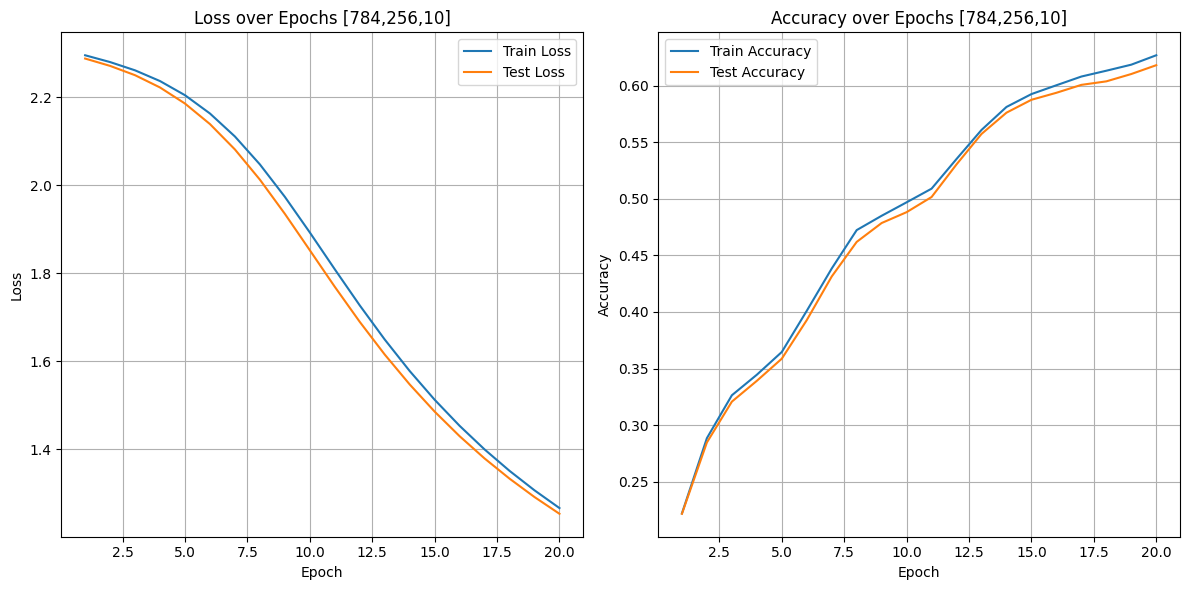

Final Test Accuracy for learning_rate 0.001: 0.6183

Training with learning_rate = 0.01
Starting training with architecture: [784, 256, 10]
Epoch 1/20: train_loss=2.1556, test_loss=1.8712, train_acc=0.4938, test_acc=0.4859
Epoch 2/20: train_loss=1.5238, test_loss=1.2670, train_acc=0.6257, test_acc=0.6190
Epoch 3/20: train_loss=1.1147, test_loss=1.0104, train_acc=0.6569, test_acc=0.6451
Epoch 4/20: train_loss=0.9321, test_loss=0.8889, train_acc=0.6793, test_acc=0.6684
Epoch 5/20: train_loss=0.8382, test_loss=0.8198, train_acc=0.6985, test_acc=0.6857
Epoch 6/20: train_loss=0.7800, test_loss=0.7726, train_acc=0.7217, test_acc=0.7099
Epoch 7/20: train_loss=0.7380, test_loss=0.7377, train_acc=0.7427, test_acc=0.7306
Epoch 8/20: train_loss=0.7035, test_loss=0.7058, train_acc=0.7576, test_acc=0.7462
Epoch 9/20: train_loss=0.6741, test_loss=0.6792, train_acc=0.7690, test_acc=0.7588
Epoch 10/20: train_loss=0.6486, test_loss=0.6576, train_acc=0.7756, test_acc=0.7665
Epoch 11/20: train_loss=0.626

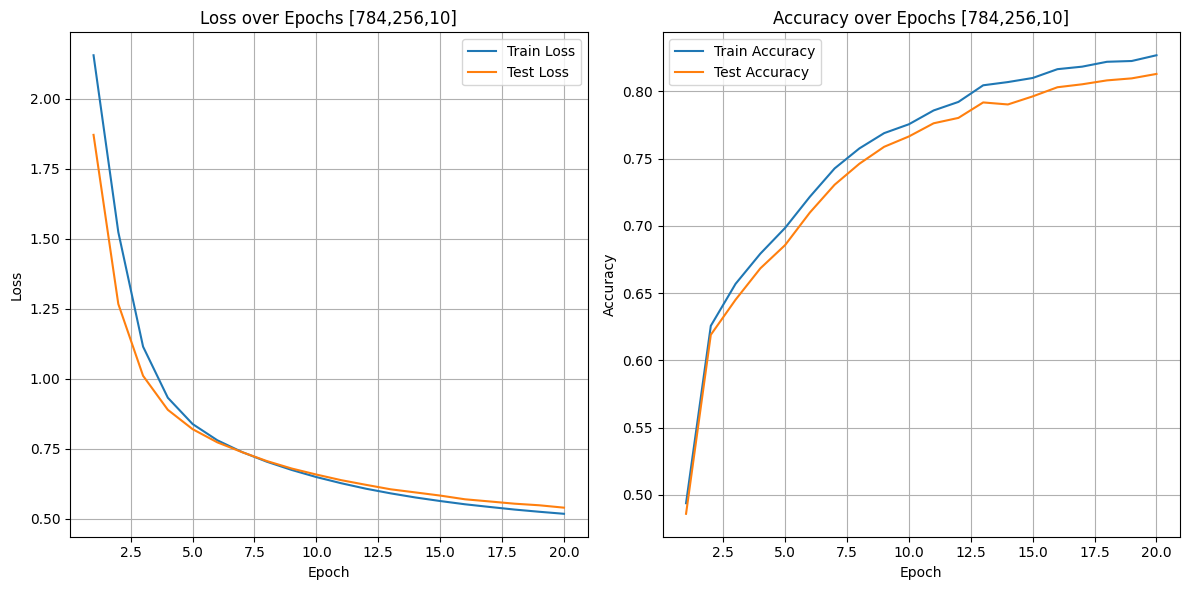

Final Test Accuracy for learning_rate 0.01: 0.8130

Training with learning_rate = 0.1
Starting training with architecture: [784, 256, 10]
Epoch 1/20: train_loss=1.0479, test_loss=0.6916, train_acc=0.7479, test_acc=0.7382
Epoch 2/20: train_loss=0.6060, test_loss=0.6146, train_acc=0.7869, test_acc=0.7731
Epoch 3/20: train_loss=0.5192, test_loss=0.5881, train_acc=0.7941, test_acc=0.7796
Epoch 4/20: train_loss=0.4824, test_loss=0.5019, train_acc=0.8332, test_acc=0.8227
Epoch 5/20: train_loss=0.4544, test_loss=0.4810, train_acc=0.8425, test_acc=0.8296
Epoch 6/20: train_loss=0.4359, test_loss=0.4675, train_acc=0.8460, test_acc=0.8335
Epoch 7/20: train_loss=0.4183, test_loss=0.4842, train_acc=0.8412, test_acc=0.8265
Epoch 8/20: train_loss=0.4023, test_loss=0.4404, train_acc=0.8586, test_acc=0.8433
Epoch 9/20: train_loss=0.3928, test_loss=0.4383, train_acc=0.8600, test_acc=0.8434
Epoch 10/20: train_loss=0.3802, test_loss=0.4184, train_acc=0.8671, test_acc=0.8535
Epoch 11/20: train_loss=0.3739,

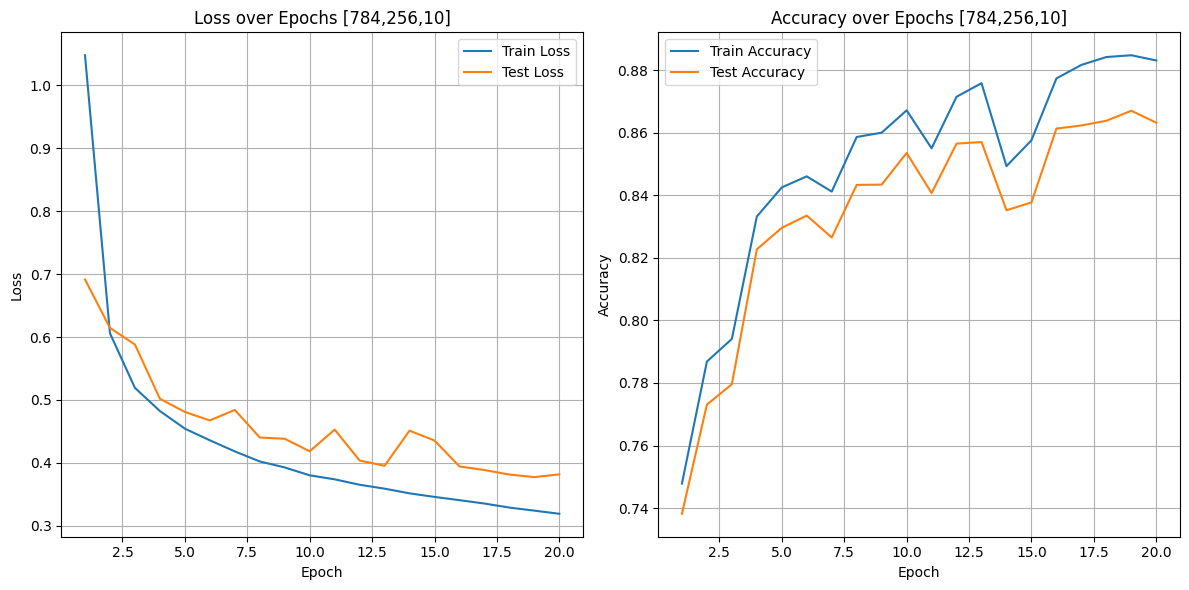

Final Test Accuracy for learning_rate 0.1: 0.8632

Training with learning_rate = 0.3
Starting training with architecture: [784, 256, 10]
Epoch 1/20: train_loss=0.8020, test_loss=0.5792, train_acc=0.7938, test_acc=0.7825
Epoch 2/20: train_loss=0.4941, test_loss=0.4930, train_acc=0.8353, test_acc=0.8235
Epoch 3/20: train_loss=0.4302, test_loss=0.4623, train_acc=0.8445, test_acc=0.8328
Epoch 4/20: train_loss=0.4020, test_loss=0.4419, train_acc=0.8558, test_acc=0.8449
Epoch 5/20: train_loss=0.3794, test_loss=0.4426, train_acc=0.8560, test_acc=0.8434
Epoch 6/20: train_loss=0.3602, test_loss=0.4623, train_acc=0.8473, test_acc=0.8310
Epoch 7/20: train_loss=0.3515, test_loss=0.3861, train_acc=0.8789, test_acc=0.8608
Epoch 8/20: train_loss=0.3343, test_loss=0.4201, train_acc=0.8653, test_acc=0.8506
Epoch 9/20: train_loss=0.3265, test_loss=0.4033, train_acc=0.8675, test_acc=0.8457
Epoch 10/20: train_loss=0.3175, test_loss=0.3783, train_acc=0.8830, test_acc=0.8670
Epoch 11/20: train_loss=0.3061, 

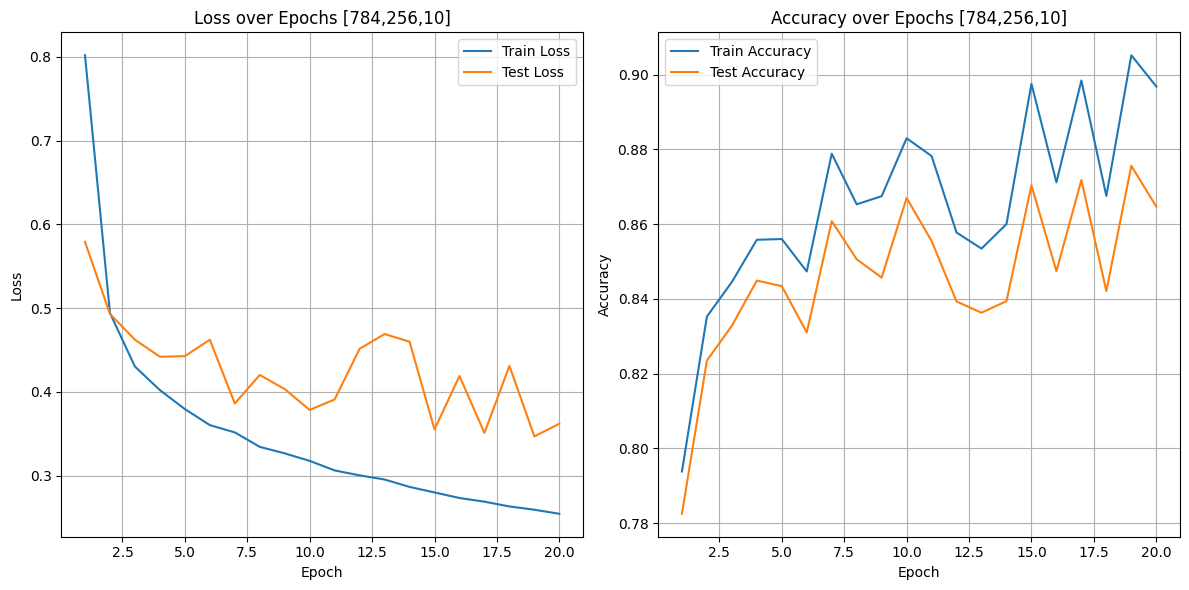

Final Test Accuracy for learning_rate 0.3: 0.8647

Training with learning_rate = 0.5
Starting training with architecture: [784, 256, 10]
Epoch 1/20: train_loss=0.8014, test_loss=0.6698, train_acc=0.7571, test_acc=0.7433
Epoch 2/20: train_loss=0.4846, test_loss=0.5424, train_acc=0.8116, test_acc=0.7963
Epoch 3/20: train_loss=0.4266, test_loss=0.4360, train_acc=0.8579, test_acc=0.8395
Epoch 4/20: train_loss=0.3860, test_loss=0.4997, train_acc=0.8328, test_acc=0.8137
Epoch 5/20: train_loss=0.3688, test_loss=0.4341, train_acc=0.8586, test_acc=0.8439
Epoch 6/20: train_loss=0.3502, test_loss=0.6637, train_acc=0.7670, test_acc=0.7542
Epoch 7/20: train_loss=0.3496, test_loss=0.3983, train_acc=0.8723, test_acc=0.8544
Epoch 8/20: train_loss=0.3261, test_loss=0.4289, train_acc=0.8582, test_acc=0.8338
Epoch 9/20: train_loss=0.3141, test_loss=0.3697, train_acc=0.8890, test_acc=0.8691
Epoch 10/20: train_loss=0.3077, test_loss=0.3739, train_acc=0.8847, test_acc=0.8634
Epoch 11/20: train_loss=0.2968, 

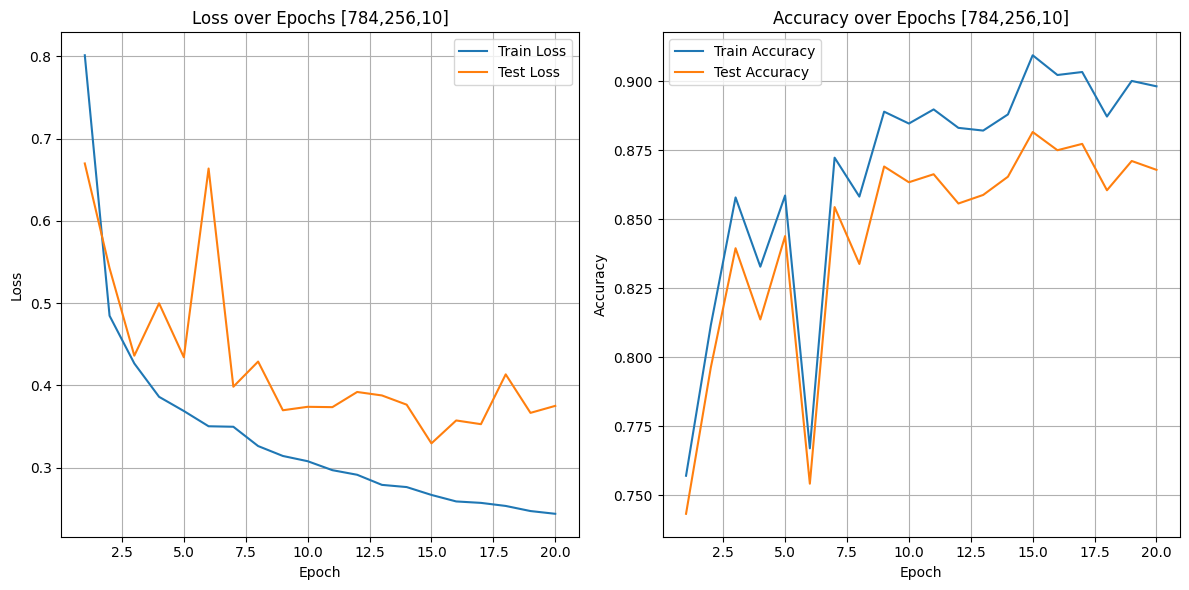

Final Test Accuracy for learning_rate 0.5: 0.8679

Training with learning_rate = 1
Starting training with architecture: [784, 256, 10]
Epoch 1/20: train_loss=1.7184, test_loss=1.7083, train_acc=0.3288, test_acc=0.3282
Epoch 2/20: train_loss=1.8945, test_loss=1.4122, train_acc=0.4451, test_acc=0.4431
Epoch 3/20: train_loss=1.4642, test_loss=1.6258, train_acc=0.3036, test_acc=0.3022
Epoch 4/20: train_loss=2.1057, test_loss=2.3027, train_acc=0.1032, test_acc=0.1036
Epoch 5/20: train_loss=2.1305, test_loss=1.7793, train_acc=0.2785, test_acc=0.2781
Epoch 6/20: train_loss=2.1139, test_loss=2.5486, train_acc=0.1056, test_acc=0.1051
Epoch 7/20: train_loss=2.1173, test_loss=1.9742, train_acc=0.1885, test_acc=0.1886
Epoch 8/20: train_loss=2.1982, test_loss=2.3031, train_acc=0.1010, test_acc=0.1008
Epoch 9/20: train_loss=2.2104, test_loss=2.3029, train_acc=0.1001, test_acc=0.1000
Epoch 10/20: train_loss=2.2440, test_loss=2.3035, train_acc=0.1002, test_acc=0.1002
Epoch 11/20: train_loss=2.1379, te

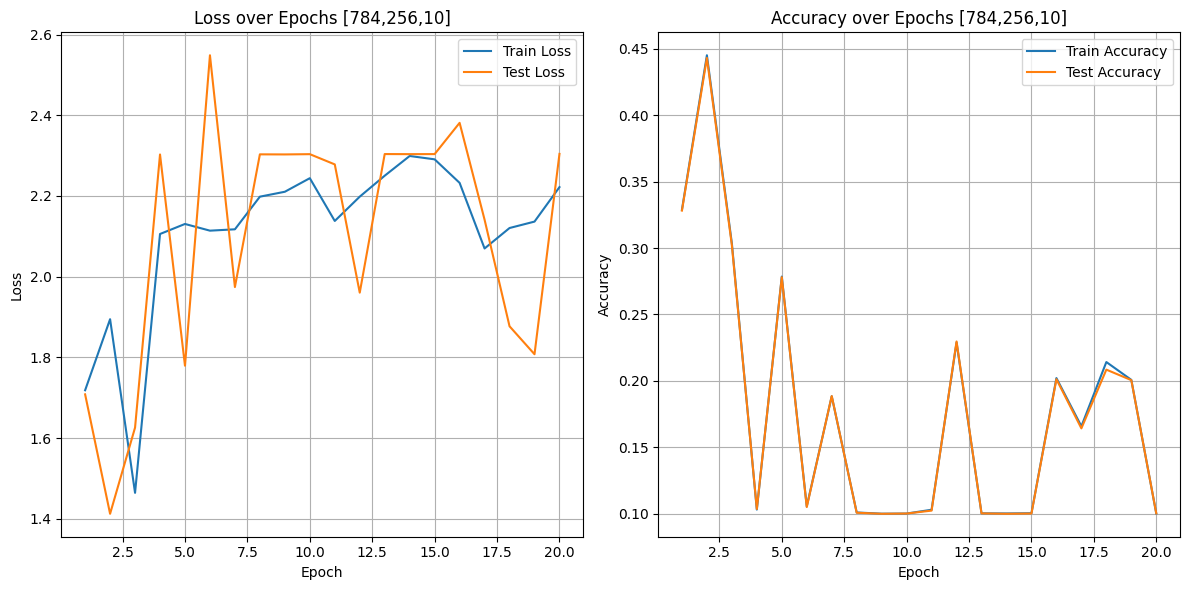

Final Test Accuracy for learning_rate 1: 0.1003


In [33]:
lrs = [0.001, 0.01, 0.1, 0.3, 0.5, 1]
layer_dimensions  = [784, 256, 10]
num_epochs        = 20

final_test_accuracies = []
best_accuracy = 0.0
best_num_hiddens = 0

for learning_rate in lrs:
  print(f"\nTraining with learning_rate = {learning_rate}")
  trained_epochs, t_losses, v_losses, t_accs, v_accs, trained_params = train_model_n_hidden_layers(
          layer_dims=layer_dimensions,
          learning_rate=learning_rate,
          sigma=sigma,
          num_epochs=num_epochs
      )
  layer_dims_for_plot = str(layer_dimensions).replace(" ","")
  show_training_graphs(trained_epochs, t_losses, v_losses, t_accs, v_accs, layer_dims_str=layer_dims_for_plot)
  final_test_accuracies.append(v_accs[-1])
  print(f"Final Test Accuracy for learning_rate {learning_rate}: {v_accs[-1]:.4f}")
  if v_accs[-1] > best_accuracy:
      best_accuracy = v_accs[-1]
      best_num_hiddens = num_hidden

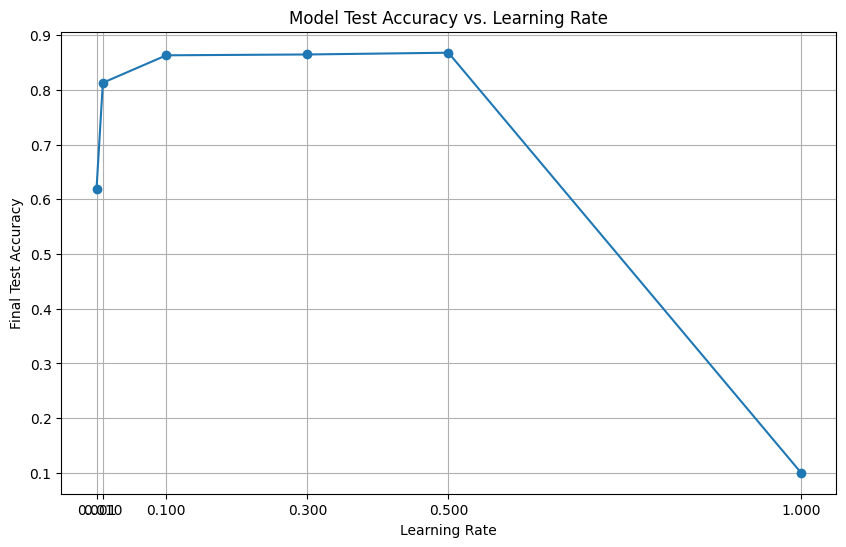

In [34]:
# Vẽ đồ thị
plt.figure(figsize=(10, 6))
plt.plot(lrs, final_test_accuracies, marker='o', linestyle='-')
plt.title('Model Test Accuracy vs. Learning Rate')
plt.xlabel('Learning Rate')
plt.ylabel('Final Test Accuracy')
plt.xticks(lrs)
plt.grid(True)

*   Khi tăng epoch:
  *   Độ chính xác của mô hình cũng tăng.
  *   Độ ổn định giảm mạnh hơn khi learning rate tăng cao.